In [1]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(VennDiagram)
options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
functR <- sprintf('%sFunctions_prediction_plots.R', fold_notebook)
source(functR)
color_file <- sprintf('%scolor_tissues.txt', fold_notebook)

fold <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/OUTPUT_all/'
pheno <- 'SCZ'
fold_rep <- 'SCZ_PGC/eQTL_PROJECT/replication_CMC/'
# train_fold <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/'
train_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_SCZ-PGC/'
type_dat <- 'SCZ-PGC'
pval_FDR <- 0.05

# load results
color_tissues <- read.table(color_file, h=T, stringsAsFactors = F)
tscore <- read.delim(sprintf('%stscore_pval_%s_covCorr.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathR <- read.delim(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathGO <- read.delim(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathWiki <- read.delim(sprintf('%scustomPath_WikiPath2019Human_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')
pathCMC <- read.delim(sprintf('%scustomPath_CMC_GeneSets_pval_%s_covCorr_filt.txt', fold, pheno), h=T, stringsAsFactors = F, sep = '\t')

tissues <- unique(tscore$tissue)
train_fold <- c('/psycl/g/mpsziller/lucia/PriLer_PROJECT_CMC/OUTPUT_SCZ-PGC_SCRIPTS_v2/train_All/200kb/',
                paste0(train_fold, tissues[!tissues %in% 'DLPC_CMC'], '/200kb/PGC_GWAS_bin1e-2/'))
out_fold <- sprintf('%sSCZ_TWAS_PALAS/', fold_notebook)

# gene location
tscore$start_position <- NA
tscore$chrom <- NA
tscore$TSS_start <- NA

for(i in 1:length(train_fold)){
  
  tmp <- read.table(sprintf('%s/resPrior_regEval_allchr.txt', train_fold[i]), h=T,stringsAsFactors = F)
  tmp <- tmp[match(tscore$ensembl_gene_id[tscore$tissue == tissues[i]], tmp$ensembl_gene_id),]
  tscore$start_position[tscore$tissue == tissues[i]] <- tmp$start_position
  tscore$chrom[tscore$tissue == tissues[i]] <- tmp$chrom
  tscore$TSS_start[tscore$tissue == tissues[i]] <- tmp$TSS_start 
  
}

# load loci and gwas res
tscore_loci <- fread(sprintf('%sGeneTscores_SCZ_annotated.txt', fold), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
gwas_res <- fread('refData/Original_SCZ_variants_PGC.txt.gz',  h=T, stringsAsFactors = F, sep = '\t', data.table = F)
colnames(gwas_res)[colnames(gwas_res) == 'CHR'] <- 'chr'
colnames(gwas_res)[colnames(gwas_res) == 'P'] <- 'p.value_gc'
colnames(gwas_res)[colnames(gwas_res) == 'BP'] <- 'bp_hg19'
gwas_res$chr <- substr(gwas_res$chr, 4, 6)
gwas_res$Markername <- paste0(gwas_res$chr, ':', gwas_res$bp_hg19, '_', gwas_res$A1, '_', gwas_res$A2)
# correct pvalues
gwas_res <- gwas_res[!is.na(gwas_res$chr), ]
# correct pvalues
gwas_res$pval_corr <- p.adjust(gwas_res$p.value_gc, method = 'BH')
gwas_res$chrom <- paste0('chr', gwas_res$chr)

extra_pathway_list <- c("Bile Acids synthesis and enterohepatic circulation WP4389", 
                        "TCA Cycle and Deficiency of Pyruvate Dehydrogenase complex (PDHc) WP2453", 
                        "Insulin Signaling WP481", 
                        "Proteasome Degradation WP183",
                        "Hypothesized Pathways in Pathogenesis of Cardiovascular Disease WP3668", 
                        "Mitochondrial complex I assembly model OXPHOS system WP4324")



corrplot 0.92 loaded

Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘VennDiagram’


The following object is masked from ‘package:ggpubr’:

    rotate




[1] "C"

In [3]:
#################################
### compare results with GWAS ###
#################################
ann_loci <- data.frame(loci_id = unique(tscore_loci$loci_complete), stringsAsFactors = F)
ann_loci$chr <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][1])
tmp <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][2])
ann_loci$start <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][1])
ann_loci$end <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][2])
ann_loci$best_GWAS_pval <- NA
ann_loci$best_GWAS_sign <- NA
ann_loci$best_GWAS_signBH <- NA

for(i in 1:nrow(ann_loci)){
   start_loci <- as.numeric(ann_loci$start[i])
   end_loci <- as.numeric(ann_loci$end[i])                
   id <- gwas_res$chrom == ann_loci$chr[i] & gwas_res$bp_hg19 <= end_loci & gwas_res$bp_hg19 >= start_loci
   tmp <- gwas_res[id, ]
   if(nrow(tmp)>0){
       ann_loci$best_GWAS_pval[i] <- min(tmp$p.value_gc)
       ann_loci$best_GWAS_sign[i] <- any(tmp$p.value_gc <= 5*10^-8)
       ann_loci$best_GWAS_signBH[i] <- any(tmp$pval_corr <= 0.05)     
   }
}


In [4]:
# how many loci intersect significant GWAS results (Genomewide and BH correction)
table(ann_loci$best_GWAS_sign, ann_loci$best_GWAS_signBH)

# annotate gene table:
tscore_loci$best_GWAS_signBH <- NA
tscore_loci$best_GWAS_sign <- NA
tscore_loci$best_GWAS_pval <- NA
for(i in 1:nrow(ann_loci)){
    tscore_loci$best_GWAS_signBH[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_signBH[i]
    tscore_loci$best_GWAS_sign[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_sign[i]
    tscore_loci$best_GWAS_pval[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_pval[i]
}

# tmp <- tscore_loci[!tscore_loci$best_GWAS_signBH,c('chrom', 'external_gene_name','loci', 'tissue', 'Dx_pval', 'Dx_z')]
# tmp[order(tmp$loci),]
paste('unique new genes:', nrow(tscore_loci[!duplicated(tscore_loci$ensembl_gene_id) & !tscore_loci$best_GWAS_signBH,]))
paste('total new genes:', nrow(tscore_loci[!tscore_loci$best_GWAS_signBH,]))

       
        FALSE TRUE
  FALSE    24  170
  TRUE      0   48

[1] "unique new genes: 30"

[1] "total new genes: 32"

In [5]:
# add replication
fold_rep <- 'SCZ_PGC/eQTL_PROJECT/replication_CMC/'
tscore_repl <- fread(sprintf('%stscore_discoverySCZPGC_signFDR0.05_replicationDxCMCInfo_alltissues.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
rep_df <- data.frame(CMC_z = c(), CMC_pval = c(), stringsAsFactors = F)

for(i in 1:nrow(tscore_loci)){
    if(tscore_loci$tissue[i] == 'DLPC_CMC'){
        tmp <- tscore_repl[tscore_repl$ensembl_gene_id == tscore_loci$ensembl_gene_id[i] & tscore_repl$tissue == tscore_loci$tissue[i],]
        new <- data.frame(CMC_z = tmp$SCZCMC_rep_z, CMC_pval =tmp$SCZCMC_rep_pval,  stringsAsFactors = F)
    }else{
        new <- data.frame(CMC_z = NA, CMC_pval = NA,  stringsAsFactors = F)
    }
    rep_df <- rbind(rep_df,new)
}
tscore_complete <- cbind(tscore_loci, rep_df)
tscore_complete$replicated <- NA
tscore_complete$replicated <- sign(tscore_complete$Dx_z * tscore_complete$CMC_z)==1

tmp <- tscore_complete[!tscore_complete$best_GWAS_signBH,c('chrom', 'external_gene_name','loci', 'tissue', 'Dx_pval', 'Dx_z', 'CMC_pval', 'CMC_z')]
tmp[order(tmp$loci),]
length(unique(tmp$loci))
# save
write.table(tscore_complete, file = sprintf('%sGeneTscores_SCZ_annotated_intGWAS_withReplicationCMC.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

## check frat2 in dlpc, replicated in cmc

chrom external_gene_name loci              
491  chr10 NMT2               chr10:15-15.4Mb   
904  chr10 CDHR1              chr10:85.8-86.2Mb 
198  chr10 FRAT2              chr10:98.9-99.3Mb 
500  chr11 IGHMBP2            chr11:68.5-68.9Mb 
682  chr12 MLF2               chr12:6.7-7.1Mb   
1227 chr12 MLF2               chr12:6.7-7.1Mb   
504  chr12 LEMD3              chr12:65.4-65.8Mb 
915  chr14 RP11-407N17.5      chr14:39.5-39.9Mb 
234  chr15 AP4E1              chr15:51-51.4Mb   
844  chr17 TOB1-AS1           chr17:48.7-49.2Mb 
935  chr17 RP11-700H6.4       chr17:48.7-49.2Mb 
293  chr19 TMEM91             chr19:41.6-42.1Mb 
743  chr19 EXOSC5             chr19:41.6-42.1Mb 
1066 chr19 CCDC97             chr19:41.6-42.1Mb 
51   chr2  STEAP3             chr2:119.8-120.2Mb
55   chr2  TTN                chr2:179.5-179.9Mb
300  chr21 TCP10L             chr21:33.8-34.2Mb 
301  chr21 BRWD1              chr21:40.5-40.9Mb 
575  chr3  IGSF11             chr3:118.7-119.1Mb
74   chr3  RP11-553K23.2      chr3:139.1-139.5Mb
766  chr3  MRPS25             chr3:14.9-15.3Mb  
577  chr4  AC021860.1         chr4:38.5-38.9Mb  
76   chr4  CEP135             chr4:56.6-57Mb    
473  chr6  RP1-101K10.6       chr6:153.1-153.5Mb
161  chr7  DPY19L1P1          chr7:32.3-33Mb    
365  chr7  AC018641.7         chr7:32.3-33Mb    
898  chr7  AC018641.7         chr7:32.3-33Mb    
1107 chr7  RP11-225B17.2      chr7:32.3-33Mb    
475  chr7  PKD1L1             chr7:47.6-48.2Mb  
649  chr7  LINC00525          chr7:47.6-48.2Mb  
980  chr8  POLB               chr8:42-42.4Mb    
1213 chr8  RP11-1023P17.2     chr8:53-53.4Mb    
     tissue                                Dx_pval      Dx_z      CMC_pval  
491  Brain_Cerebellar_Hemisphere           2.391460e-03 -3.036747         NA
904  Brain_Frontal_Cortex_BA9              1.749773e-03 -3.129713         NA
198  DLPC_CMC                              2.405818e-03 -3.034942 0.20948361
500  Brain_Cerebellar_Hemisphere           1.689124e-03 -3.140061         NA
682  Brain_Cerebellum                      2.123934e-03 -3.072332         NA
1227 Cells_EBV-transformed_lymphocytes     8.473889e-05 -3.930587         NA
504  Brain_Cerebellar_Hemisphere           2.575922e-03  3.014277         NA
915  Brain_Frontal_Cortex_BA9              2.178312e-03  3.064779         NA
234  DLPC_CMC                              1.400150e-03  3.194620 0.44923863
844  Brain_Cortex                          1.662417e-03 -3.144727         NA
935  Brain_Frontal_Cortex_BA9              6.205975e-04 -3.422449         NA
293  DLPC_CMC                              1.340849e-04  3.818832 0.77533413
743  Brain_Cerebellum                      2.559290e-03 -3.016242         NA
1066 Brain_Hypothalamus                    1.002937e-03 -3.289701         NA
51   DLPC_CMC                              2.173198e-03  3.065482 0.17579658
55   DLPC_CMC                              1.753626e-03 -3.129066 0.67446598
300  DLPC_CMC                              7.324729e-04  3.377127 0.09948149
301  DLPC_CMC                              2.150610e-03  3.068605 0.77595625
575  Brain_Cerebellum                      2.921136e-03 -2.975917         NA
74   DLPC_CMC                              1.652047e-03 -3.146558 0.91809521
766  Brain_Cortex                          1.131593e-03  3.255584         NA
577  Brain_Cerebellum                      2.725549e-03 -2.997107         NA
76   DLPC_CMC                              1.586136e-03 -3.158444 0.47240793
473  Brain_Cerebellar_Hemisphere           2.344453e-03 -3.042727         NA
161  DLPC_CMC                              9.768379e-04  3.297114 0.04617969
365  Brain_Caudate_basal_ganglia           2.915439e-04 -3.622700         NA
898  Brain_Frontal_Cortex_BA9              5.442828e-04 -3.457960         NA
1107 Brain_Nucleus_accumbens_basal_ganglia 7.129961e-04  3.384532         NA
475  Brain_Cerebellar_Hemisphere           1.855135e-03  3.112494         NA
649  Brain_Cerebellum                      2.142654e-03  3.069712         NA
9

[1] 24

In [6]:
print(paste("N. of tissue specific SCZ loci:", length(unique(tscore_loci$loci_tissue_specific))))
print(paste("N. of SCZ loci:", length(unique(tscore_loci$loci))))

[1] "N. of tissue specific SCZ loci: 475"
[1] "N. of SCZ loci: 242"


In [7]:
tscore[tscore$external_gene_name == 'DDHD2',c('external_gene_name', 'tissue', 'Dx_pval', 'Dx_z', 'Dx_pval_BHcorr')]

external_gene_name tissue                            Dx_pval     
2963  DDHD2              DLPC_CMC                          2.297983e-05
13052 DDHD2              Brain_Cerebellum                  5.623063e-05
25404 DDHD2              Cells_EBV-transformed_lymphocytes 2.035319e-04
      Dx_z      Dx_pval_BHcorr
2963  -4.233778 0.001593021   
13052 -4.028095 0.002826730   
25404 -3.714592 0.008091178

[1] "n. of genes from novel location and TWAS identified genes: 0"


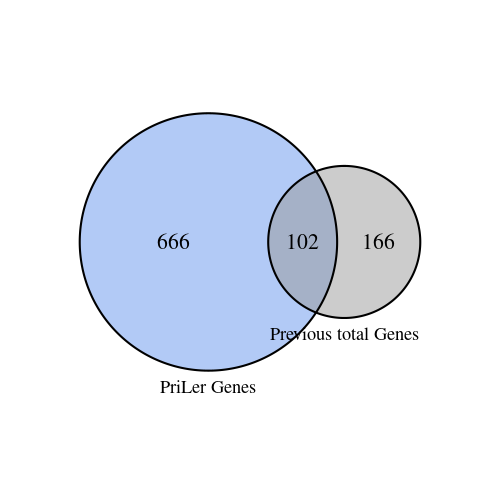

In [8]:
#################################################
### intersect with prediXcan and TWAS results ###
#################################################
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
previous_genes_file <- 'SCZ_PGC/eQTL_PROJECT/previousGenes_TWAS_prediXcan.RData'
venn_pl <- venn_plot_genes(genes_known_file = previous_genes_file, tscore = tscore, pval_FDR = pval_FDR, 
                type_mat = 'path', fold = out_fold, type_dat = type_dat)

grid.draw(venn_pl[[length(venn_pl)]])

previous_genes <- get(load(previous_genes_file))
n_int <- length(intersect(previous_genes$total, tscore_complete[!tscore_complete$best_GWAS_signBH,c('external_gene_name')]))
print(paste('n. of genes from novel location and TWAS identified genes:', n_int))


[1] 1

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                     ERG_Epi                      MRG_Epi 
                          21                           23 
         SubstantiaNigra_Epi          AnteriorCaudate_Epi 
                          34                           31 
          MidFrontalLobe_Epi             AngularGyrus_Epi 
                          32                           31 
          CingulateGyrus_Epi        HippocampusMiddle_Epi 
                          33                           32 
    InferiorTemporalLobe_Epi                       NE_Epi 
                          29                           26 
                   dNPCs_Epi     FPC_Neuronal_ATAC_R2_Epi 
                          19                            0 
    FPC_Neuronal_ATAC_R4_Epi Ctrl_150_allPeaks_cellRanger 
                           0                           13 

 0  1  2  5  6  7  8  9 10 11 12 
60  1  3  2  2  7  4  1  2  7  9 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


[1] 98  6

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                     ERG_Epi                      MRG_Epi 
                          19                           21 
         SubstantiaNigra_Epi          AnteriorCaudate_Epi 
                          32                           29 
          MidFrontalLobe_Epi             AngularGyrus_Epi 
                          30                           29 
          CingulateGyrus_Epi        HippocampusMiddle_Epi 
                          31                           30 
    InferiorTemporalLobe_Epi                       NE_Epi 
                          27                           25 
                   dNPCs_Epi     FPC_Neuronal_ATAC_R2_Epi 
                          18                            0 
    FPC_Neuronal_ATAC_R4_Epi Ctrl_150_allPeaks_cellRanger 
                           0                           12 

 0  1  2  5  6  7  8 10 11 12 
65  1  3  2  2  7  4  2  7  8 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


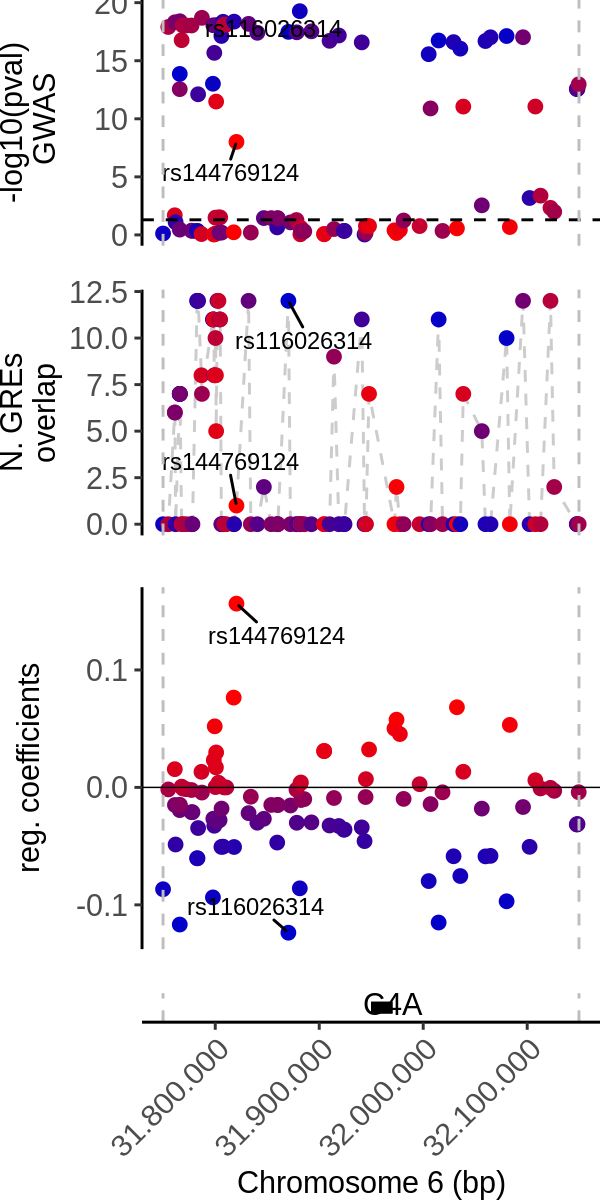

[1] 101   6

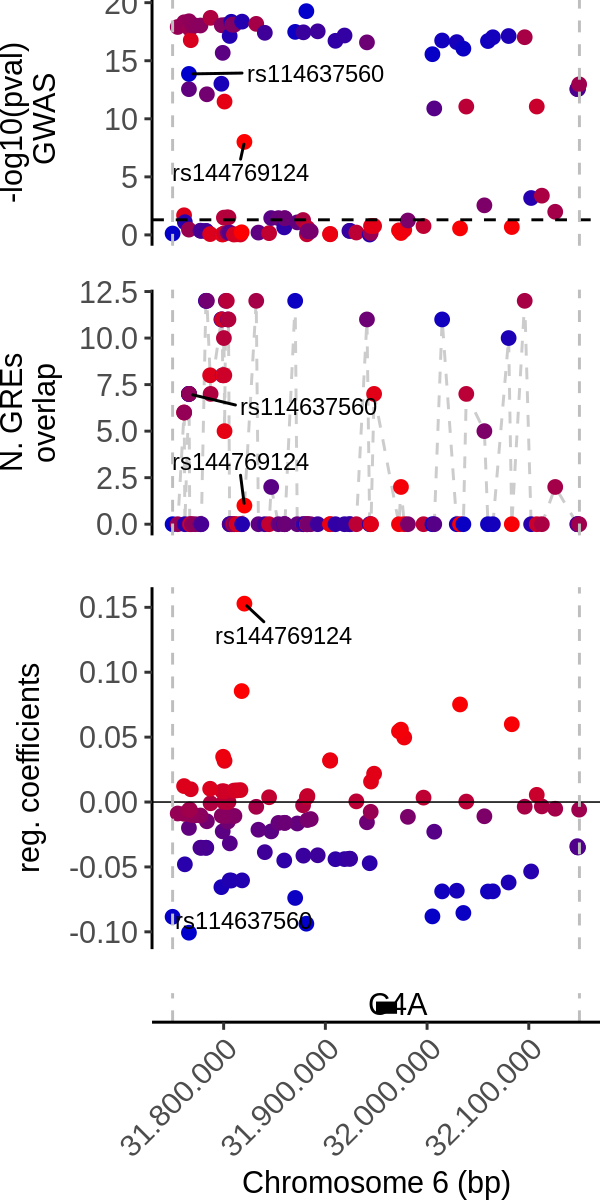

In [9]:
########################################################
#### plot results for a gene regulation from PriLer ####
########################################################

options(repr.plot.width = 3, repr.plot.height = 6, repr.plot.res = 200)
source(functR)

gwas_new <- gwas_res %>% dplyr::rename(CHROM = chr, POS = bp_hg19, P=p.value_gc)
gene_chosen <- 'C4A'
tissue <- 'DLPC_CMC'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_CMC/OUTPUT_SCZ-PGC_SCRIPTS_v2/'
prior_id_file <- sprintf('%s/priorName_SCZgwas_withIndex.txt', prior_fold)
id_tissue <- which(tissues == tissue)
id_tissue 

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_new, ID_name = 'ID_PGC', 
                               prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore_complete, 
                               n_show_rs = 2)
pl_tot$plot
dim(pl_tot$beta_reg)

ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)


pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_new, 
                               ID_name = 'ID_PGC', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = F, tscore = tscore_complete,
                               n_show_rs = 2)
pl_tot$plot
dim(pl_tot$beta_reg)
                     
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)

                     

[1] 1

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                     ERG_Epi                      MRG_Epi 
                          14                           15 
         SubstantiaNigra_Epi          AnteriorCaudate_Epi 
                          24                           23 
          MidFrontalLobe_Epi             AngularGyrus_Epi 
                          25                           26 
          CingulateGyrus_Epi        HippocampusMiddle_Epi 
                          24                           23 
    InferiorTemporalLobe_Epi                       NE_Epi 
                          22                           24 
                   dNPCs_Epi     FPC_Neuronal_ATAC_R2_Epi 
                          13                            7 
    FPC_Neuronal_ATAC_R4_Epi Ctrl_150_allPeaks_cellRanger 
                           7                            9 

 0  1  3  7  8  9 10 11 13 14 
21  1  2  3  6  1  3  3  4  4 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


[1] 48  6

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                     ERG_Epi                      MRG_Epi 
                           8                            7 
         SubstantiaNigra_Epi          AnteriorCaudate_Epi 
                          15                           13 
          MidFrontalLobe_Epi             AngularGyrus_Epi 
                          16                           16 
          CingulateGyrus_Epi        HippocampusMiddle_Epi 
                          14                           13 
    InferiorTemporalLobe_Epi                       NE_Epi 
                          12                           19 
                   dNPCs_Epi     FPC_Neuronal_ATAC_R2_Epi 
                           4                            4 
    FPC_Neuronal_ATAC_R4_Epi Ctrl_150_allPeaks_cellRanger 
                           3                            4 

 0  1  2  3  7  8  9 10 11 13 14 
50  3  1  4  3  4  1  2  2  1  1 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


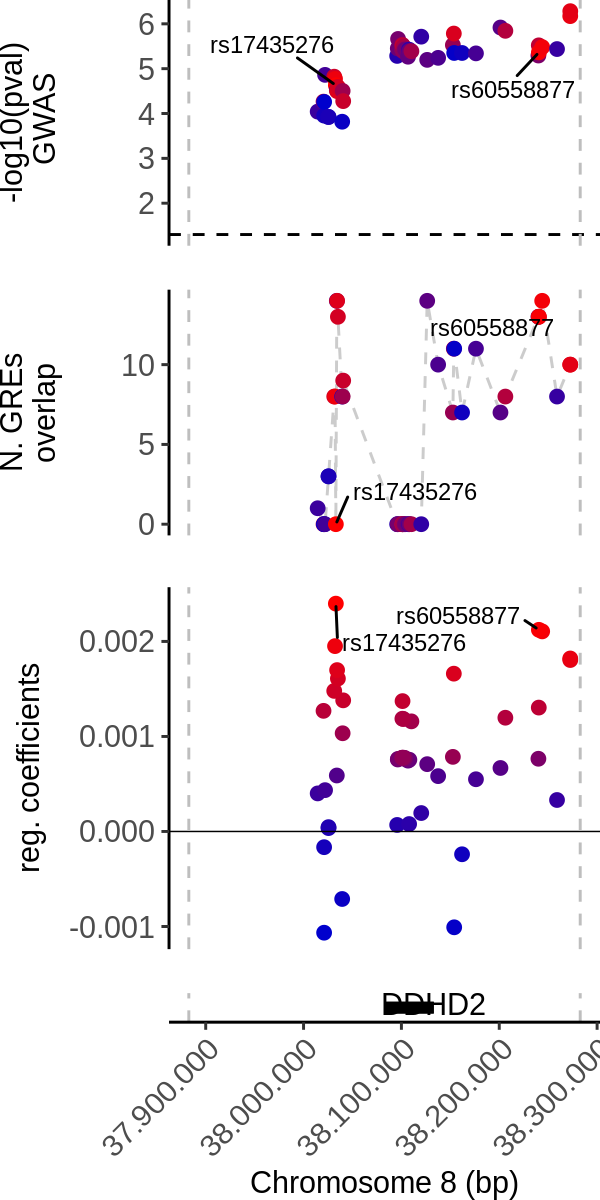

[1] 72  6

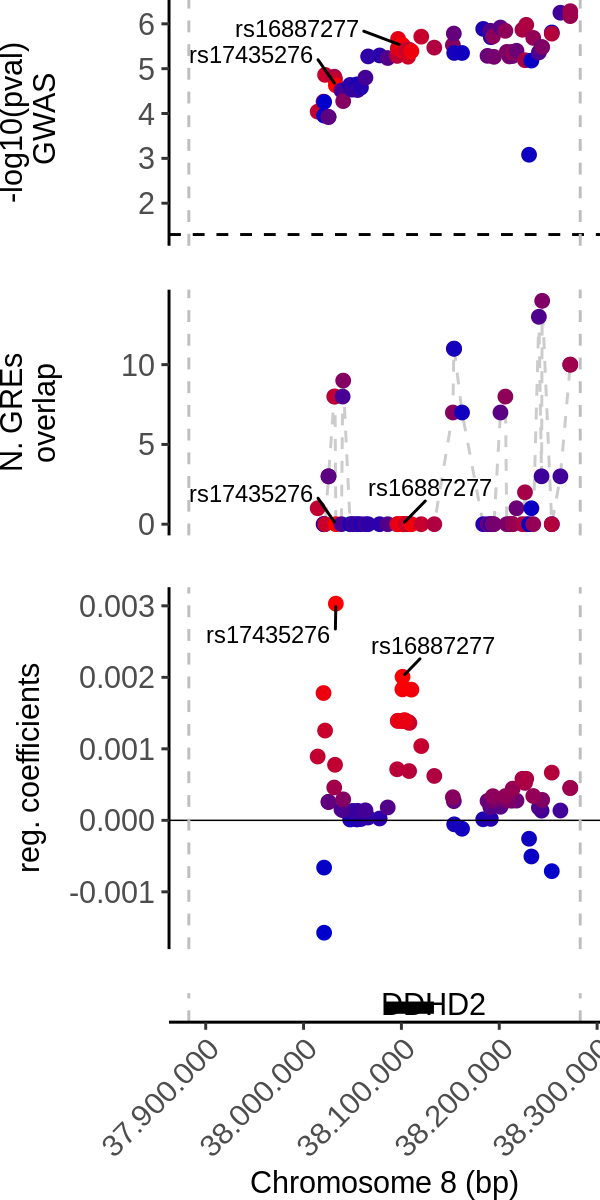

In [10]:
options(repr.plot.width = 3, repr.plot.height = 6, repr.plot.res = 200)

gwas_new <- gwas_res %>% dplyr::rename(CHROM = chr, POS = bp_hg19, P=p.value_gc)
gene_chosen <- 'DDHD2'
tissue <- 'DLPC_CMC'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_CMC/OUTPUT_SCZ-PGC_SCRIPTS_v2/'
prior_id_file <- sprintf('%s/priorName_SCZgwas_withIndex.txt', prior_fold)
id_tissue <- which(tissues == tissue)
id_tissue 

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_new, ID_name = 'ID_PGC', 
                               prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore_complete, 
                               n_show_rs = 2)
pl_tot$plot
dim(pl_tot$beta_reg)

ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)


pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_new, 
                               ID_name = 'ID_PGC', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = F, tscore = tscore_complete,
                               n_show_rs = 2)
pl_tot$plot
dim(pl_tot$beta_reg)
                     
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)


In [11]:
train_out_P <- fread(sprintf('%s/%s_regEval_allchr.txt', train_fold[id_tissue], 'resPrior'))
train_out_P$test_dev_geno[train_out_P$external_gene_name == 'DDHD2']

train_out <- fread(sprintf('%s/%s_regEval_allchr.txt', train_fold[id_tissue], 'resNoPrior'))
train_out$test_dev_geno[train_out_P$external_gene_name == 'DDHD2']

[1] 0.07208432

[1] 0.07167438

[1] 3

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                         ERG                          MRG 
                           7                            8 
            substantia_nigra             anterior_caudate 
                           4                            4 
            mid_frontal_lobe                angular_gyrus 
                           3                            5 
             cingulate_gyrus           hippocampus_middle 
                           6                            6 
      inferior_temporal_lobe                           NE 
                           6                            7 
                       dNPCs         FPC_neuronal_ATAC_R2 
                           6                            1 
        FPC_neuronal_ATAC_R4 Ctrl_150_allPeaks_cellRanger 
                           3                            0 

 0  3  4  7  9 10 11 
16  1  4  1  1  2  1 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


[1] 26  6

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                         ERG                          MRG 
                           7                            7 
            substantia_nigra             anterior_caudate 
                           3                            5 
            mid_frontal_lobe                angular_gyrus 
                           3                            5 
             cingulate_gyrus           hippocampus_middle 
                           5                            7 
      inferior_temporal_lobe                           NE 
                           5                            6 
                       dNPCs         FPC_neuronal_ATAC_R2 
                           6                            0 
        FPC_neuronal_ATAC_R4 Ctrl_150_allPeaks_cellRanger 
                           2                            0 

 0  3  4  6  7 10 11 
23  1  2  2  1  2  1 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


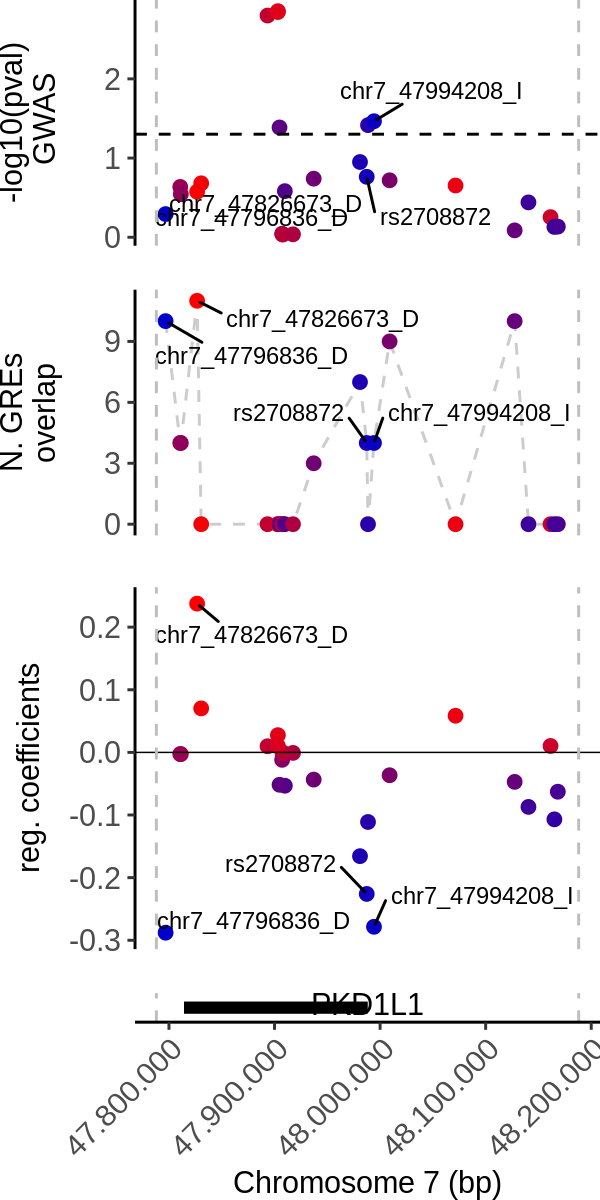

[1] 32  6

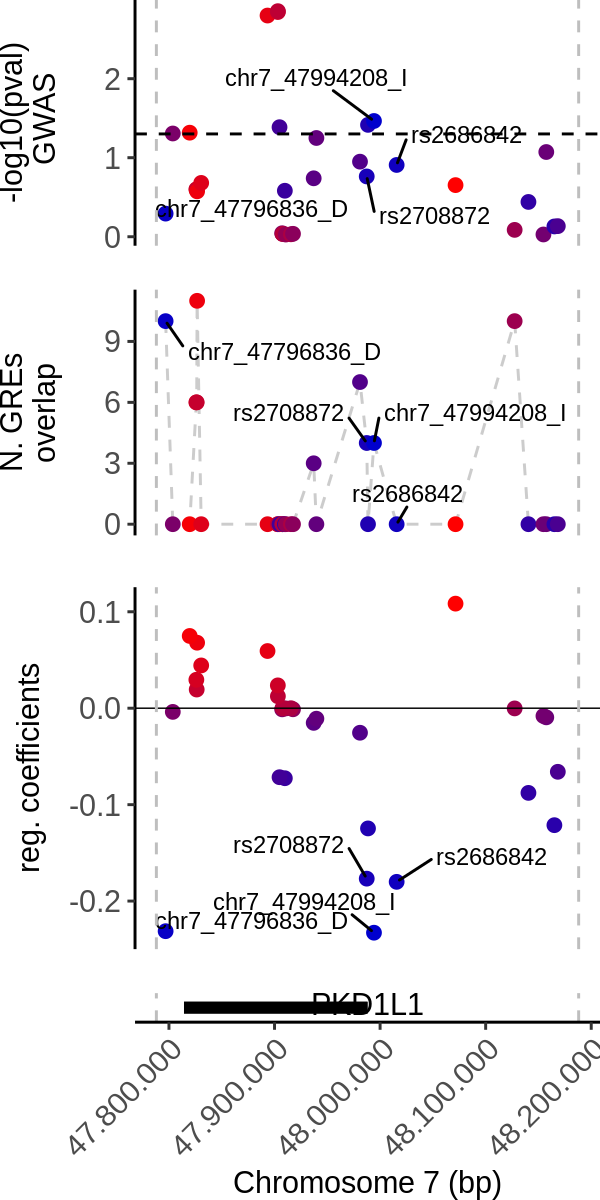

In [12]:
options(repr.plot.width = 3, repr.plot.height = 6, repr.plot.res = 200)
source(functR)

gwas_new <- gwas_res %>% dplyr::rename(CHROM = chr, POS = bp_hg19, P=p.value_gc)
gene_chosen <- 'PKD1L1'
tissue <- 'Brain_Cerebellar_Hemisphere'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_SCZ-PGC/'
prior_id_file <- sprintf('%s%s/priorName_PGCgwas_withIndex.txt', prior_fold, tissue)
id_tissue <- which(tissues == tissue)
id_tissue 

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_new, ID_name = 'ID_PGC', 
                               prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore_complete, 
                               n_show_rs = 4)
pl_tot$plot
dim(pl_tot$beta_reg)

ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)


pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_new, 
                               ID_name = 'ID_PGC', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = F, 
                               tscore = tscore_complete,
                               n_show_rs = 4)
pl_tot$plot
dim(pl_tot$beta_reg)
                     
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)

                     

In [13]:
############################################
### annotate pathway significant results ###
############################################

common_i <- intersect(colnames(pathR), colnames(pathGO))
common_i <- intersect(common_i, colnames(pathWiki))
common_i <- intersect(common_i, colnames(pathCMC))
tmp1 <- pathR[, common_i]
tmp2 <- pathGO[, common_i]
tmp3 <- pathWiki[, common_i]
tmp4 <- pathCMC[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tmp3$type_path <- 'WikiHuman'
tmp4$type_path <- 'CMCGeneSet'
tot_path <- rbind(tmp1, tmp2, tmp3, tmp4)
# consider only significant ones:
tot_path <- tot_path[, !colnames(tot_path) %in% 'Dx_pval_BHcorr_overall']
sign_path <- tot_path[tot_path[,15]<= 0.05,]

# add a column that indicates whether there is any gene from new loci
sign_path$gene_from_newloci <- NA

for(i in 1:nrow(sign_path)){
    
    id <- sapply(tscore_complete$external_gene_name, function(x) grepl(x, sign_path$genes_path[i])) & sign_path$tissue[i] == tscore_complete$tissue
    id <- id & !tscore_complete$best_GWAS_signBH
    if(any(id)){
        sign_path$gene_from_newloci[i] <- paste0(unique(tscore_complete$external_gene_name[id]), collapse = ',')
    }
}
paste('pathway from new loci:', sum(!is.na(sign_path$gene_from_newloci)), 'out of', nrow(sign_path))
sign_path[!is.na(sign_path$gene_from_newloci),]
table(sign_path$type_path)

# add replication
pathR_repl <- fread(sprintf('%spathR_discoverySCZPGC_signFDR0.05_replicationDxCMCInfo_alltissues.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
pathGO_repl <- fread(sprintf('%spathGO_discoverySCZPGC_signFDR0.05_replicationDxCMCInfo_alltissues.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
common_i <- intersect(colnames(pathR_repl), colnames(pathGO_repl))
tmp1 <- pathR_repl[, common_i]
tmp2 <- pathGO_repl[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tot_path_repl <- rbind(tmp1, tmp2)

rep_df <- data.frame(CMC_z = c(), CMC_pval = c(), stringsAsFactors = F)
for(i in 1:nrow(sign_path)){
    if(sign_path$tissue[i] == 'DLPC_CMC' & sign_path$type_path[i] %in% c('Reactome', 'GO')){
        tmp <- tot_path_repl[tot_path_repl$path == sign_path$path[i] & tot_path_repl$tissue == sign_path$tissue[i],]
        new <- data.frame(CMC_z = tmp$SCZCMC_rep_z, CMC_pval =tmp$SCZCMC_rep_pval, stringsAsFactors = F)
    }else{
        new <- data.frame(CMC_z = NA, CMC_pval = NA, stringsAsFactors = F)
    }
    rep_df <- rbind(rep_df,new)
}
path_complete <- cbind(sign_path, rep_df)
path_complete$replicated <- NA
path_complete$replicated <- sign(path_complete$Dx_z * path_complete$CMC_z)==1
# replicated pathways with genes from new loci
table(path_complete$replicated, !is.na(path_complete$gene_from_newloci))
# save
write.table(path_complete, file = sprintf('%sPathScores_SCZ_annNewLoci_withReplicationCMC.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)
                 

[1] "pathway from new loci: 17 out of 1578"

path                                                                     
2387  Membrane binding and targetting of GAG proteins                          
7922  multivesicular body                                                      
7984  clathrin-coated pit                                                      
9330  enzyme binding                                                           
10689 regulation of protein kinase activity                                    
13556 nucleotide binding                                                       
13850 protein binding                                                          
14552 nucleoside-triphosphatase activity                                       
14577 viral protein processing                                                 
14732 negative regulation of BMP signaling pathway                             
15466 calcium ion transmembrane transport                                      
16272 defense response                                                         
17273 transcriptionally active chromatin                                       
17310 regulation of growth                                                     
21730 enzyme binding                                                           
28451 Nucleotide Metabolism WP404                                              
29273 HBA:Reticular_Nucleus_of_Thalamus_localMarker(top200)_IN_Ventral_Thalamus
      ngenes_tscore ngenes_path mean_dev_geno sd_dev_geno mean_test_dev_geno
2387    2             15        0.1140201     0.03992997  0.02489901        
7922    5             19        0.1577076     0.09563383  0.09017098        
7984   16             53        0.1413775     0.12049798  0.08603877        
9330   86            259        0.1407879     0.10192274  0.08101899        
10689   9             19        0.1553011     0.07971658  0.07550657        
13556  52            564        0.1807091     0.14750738  0.10036021        
13850 799           9305        0.1903060     0.16252953  0.09162340        
14552  15            143        0.2383471     0.13707363  0.13218043        
14577   2             12        0.1140201     0.03992997  0.02489901        
14732   3             35        0.2419276     0.34429778  0.11918578        
15466   6             53        0.2390719     0.14985713  0.07266223        
16272  11            107        0.2755137     0.13541648  0.12418542        
17273   2             11        0.1419488     0.10556373  0.04530145        
17310   3             54        0.1099316     0.06428465  0.01015209        
21730  13            259        0.0706922     0.08785964  0.02122251        
28451   2             19        0.1578572     0.13834791  0.11144517        
29273  69            200        0.1527335     0.10897996  0.08923240        
      sd_test_dev_geno mean_gene_corr sd_gene_corr Dx_beta     ⋯ Dx_qval     
2387  0.028179741       2.581702e-03          NA   -0.04352529 ⋯ 1.894927e-02
7922  0.098223877      -2.670464e-03  0.03351222   -0.08039933 ⋯ 3.670498e-03
7984  0.115094775       1.142664e-04  0.03393972    0.11733856 ⋯ 2.304980e-02
9330  0.089706135       2.594174e-04  0.03592551   -0.27916546 ⋯ 1.876957e-02
10689 0.071230838      -6.140652e-04  0.03279106   -0.15535321 ⋯ 4.208603e-06
13556 0.128964206       2.355966e-05  0.03389847    0.21867200 ⋯ 1.307449e-02
13850 0.122385180       7.494400e-05  0.03689975    0.99352361 ⋯ 2.246002e-03
14552 0.126456094      -2.698716e-04  0.03413809    0.12819125 ⋯ 6.203159e-03
14577 0.028179741       2.581702e-03          NA   -0.04352529 ⋯ 1.162756e-02
14732 0.186485698       4.739243e-03  0.02533271    0.05909681 ⋯ 4.710133e-03
15466 0.102205466      -1.675367e-04  0.03324356    0.07737963 ⋯ 9.247002e-03
16272 0.136040185       3.289870e-03  0.03768810   -0.11730176 ⋯ 2.299835e-03
17273 0.006606398       4.423402e-03          NA   -0.03844678 ⋯ 3.209519e-02
17310 0.006792579       5.471375e-03  0.03505505   -0.05493659 ⋯ 9.496187e-03
21730 0.03


CMCGeneSet         GO   Reactome  WikiHuman 
         8       1020        376        174 

       
        FALSE TRUE
  FALSE    90    2
  TRUE    167    2

In [14]:
summary(path_complete$CMC_pval)
table(path_complete$replicated, path_complete$type_path)
a=path_complete[path_complete$replicated & path_complete$CMC_pval <= 0.05,]
a = a[!is.na(a$path),]
a[order(a$CMC_pval, decreasing = F),c('path', 'ngenes_tscore', 'ngenes_path', 
                                      'mean_dev_geno', 'Dx_pval', 'Dx_z', 'genes_path', 
                                      'CMC_z', 'CMC_pval', 'replicated')]
table(path_complete$replicated & path_complete$CMC_pval <= 0.05, path_complete$type_path)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0026  0.1611  0.4107  0.4444  0.6843  0.9978    1317 

       
        CMCGeneSet  GO Reactome WikiHuman
  FALSE          0  75       17         0
  TRUE           0 119       50         0

path                                       ngenes_tscore ngenes_path
7981  caveola                                    23            60         
11634 caveolin-mediated endocytosis               4             5         
9325  protein kinase regulator activity           3             7         
11512 response to epidermal growth factor         2             5         
8000  protein kinase CK2 complex                  2             2         
751   Negative regulation of FGFR4 signaling      9            31         
1103  Signal attenuation                          2            10         
8337  complement activation, classical pathway    8            39         
437   Fructose catabolism                         2             5         
3     A third proteolytic cleavage releases NICD  3             9         
7243  condensed chromosome outer kinetochore      2             9         
      mean_dev_geno Dx_pval      Dx_z     
7981  0.09907802    1.045931e-03  3.277871
11634 0.13609995    1.417328e-03  3.191099
9325  0.11766849    5.916581e-11 -6.545830
11512 0.10392632    5.567997e-04  3.451829
8000  0.13003070    2.731670e-12 -6.990880
751   0.14622468    3.520868e-04  3.573615
1103  0.10249640    5.177260e-04  3.471414
8337  0.23402480    1.399947e-07  5.265255
437   0.10035409    2.092011e-03  3.076849
3     0.03864334    1.053306e-04  3.877973
7243  0.14877014    2.580820e-04  3.654104
      genes_path                                                                                                                              
7981  LRP8,SCN5A,ATP1B3,P2RY12,F2R,EFNA5,FLOT1,SMPD2,ADCYAP1R1,CAV2,CAV1,JAK2,BMPR1A,MYOF,KCNA5,LRP6,AKAP6,MAPK3,CDH13,FLOT2,PTRF,PACSIN2,MLC1
11634 CAV1,MAPK3,PACSIN2,MLC1                                                                                                                 
9325  NCK1,CSNK2B,LY6G5B                                                                                                                      
11512 BRAF,MAPK3                                                                                                                              
8000  CSNK2B,LY6G5B                                                                                                                           
751   MKNK1,KLB,FGF2,FGF1,BRAF,CBL,MAPK3,GRB2,UBA52                                                                                           
1103  MAPK3,GRB2                                                                                                                              
8337  C1QA,CD55,CR1,CD46,C4A,C4B,C5,C1RL                                                                                                      
437   GLYCTK,ALDOB                                                                                                                            
3     NOTCH4,NOTCH1,PSEN1                                                                                                                     
7243  CENPE,SKA2                                                                                                                              
      CMC_z     CMC_pval    replicated
7981   3.009838 0.002613867 TRUE      
11634  2.858243 0.004259940 TRUE      
9325  -2.542221 0.011015053 TRUE      
11512  2.370373 0.017770146 TRUE      
8000  -2.215955 0.026694555 TRUE      
751    2.180646 0.029209595 TRUE      
1103   2.178747 0.029350432 TRUE      
8337   2.133428 0.032889652 TRUE      
437    2.084841 0.037083760 TRUE      
3      2.036091 0.041741210 TRUE      
7243   1.962120 0.049748478 TRUE

       
        CMCGeneSet  GO Reactome WikiHuman
  FALSE          0 187       63         0
  TRUE           0   7        4         0

[1] "It exists for T-score not concordant in sign results that reach nominal pvalue 0.05 in the replication: TRUE"


       
        FALSE TRUE
  FALSE   104    3
  TRUE    188   17

[1] "It exists for pathscore not concordant in sign results that reach nominal pvalue 0.05 in the replication: TRUE"


       
        FALSE TRUE
  FALSE    91    1
  TRUE    158   11

tissue   n   n_sign frac_sign frac       type       type_rep            
1 DLPC_CMC 312 205    0.6570513 0.60256410 T-score    replication P > 0.05
2 DLPC_CMC 312 205    0.6570513 0.05448718 T-score    replication P < 0.05
3 DLPC_CMC 261 169    0.6475096 0.60536398 Path-score replication P > 0.05
4 DLPC_CMC 261 169    0.6475096 0.04214559 Path-score replication P < 0.05

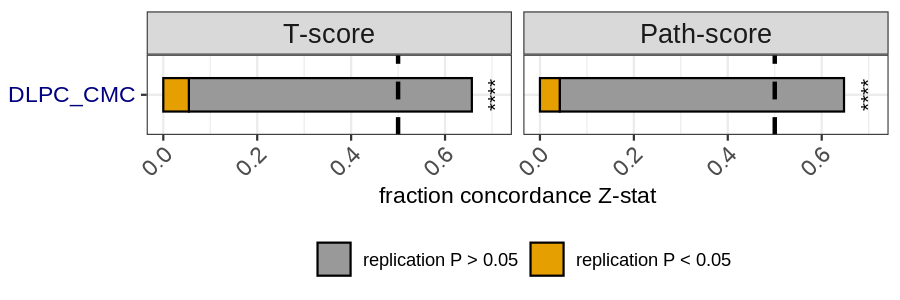

In [15]:
###############################################
### plot reproducibility on external cohort ###
###############################################
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 150)

create_df_repr <- function(df_complete, pval_nom = 0.05, type_name){
    
    tissue_spec <- df_complete %>% group_by(tissue) %>% 
    dplyr::summarise(n = length(replicated),
              n_sign = sum(replicated),
              frac_sign = sum(replicated)/length(replicated), 
              binomial_pval = binom.test(sum(replicated), length(replicated), p = 0.5, alternative = c("greater"))$p.value,
              frac_notsign = sum(!replicated)/length(replicated),
              frac_sign_nom = sum(replicated & CMC_pval <= pval_nom)/length(replicated),
              frac_sign_notnom = sum(replicated & CMC_pval > pval_nom)/length(replicated))

    df_summary <- df_complete %>% 
        dplyr::summarise(tissue = 'All tissues', n = length(replicated),
              n_sign = sum(replicated),
              frac_sign = sum(replicated)/length(replicated), 
              binomial_pval = binom.test(sum(replicated), length(replicated), p = 0.5, alternative = c("greater"))$p.value,
              frac_notsign = sum(!replicated)/length(replicated),
              frac_sign_nom = sum(replicated & CMC_pval <= pval_nom)/length(replicated),
              frac_sign_notnom = sum(replicated & CMC_pval > pval_nom)/length(replicated)) %>% 
        dplyr::bind_rows(tissue_spec) %>% dplyr::mutate(type = type_name)
    
    df_pval <- df_summary %>% dplyr::select(tissue, binomial_pval, frac_sign, type) %>% 
        dplyr::mutate(pos = frac_sign + 0.05) %>% 
        dplyr::mutate(sign_symbol = dplyr::case_when(binomial_pval <=0.05 & binomial_pval>0.01 ~ "*", 
                                       binomial_pval <=0.01 & binomial_pval>0.001 ~ "**", 
                                       binomial_pval <=0.001 & binomial_pval>0.0001 ~ "***",
                                       binomial_pval <=0.0001 ~ "****"))
    
    tmp1 <- df_summary %>% dplyr::select(tissue, n,  n_sign, frac_sign, frac_sign_notnom, type) %>% 
        dplyr::mutate(type_rep = sprintf('replication P > %.2f', pval_nom)) %>% 
    dplyr::rename( frac = frac_sign_notnom)
    tmp2 <- df_summary %>% dplyr::select(tissue, n , n_sign, frac_sign, frac_sign_nom, type) %>% 
        dplyr::mutate(type_rep = sprintf('replication P < %.2f', pval_nom)) %>% 
    dplyr::rename(frac = frac_sign_nom)
    
    output <- dplyr::bind_rows(tmp1, tmp2)
    output$type_rep <- factor(output$type_rep, 
                              levels = c(sprintf('replication P > %.2f', pval_nom),
                                         sprintf('replication P < %.2f', pval_nom)))
    output$tissue <- factor(output$tissue, levels = rev(df_summary$tissue))
    df_pval$tissue <- factor(df_pval$tissue, levels = rev(df_summary$tissue))

    return(list(pval = df_pval, frac = output))

}

## tscore: 
val <- any(!tscore_complete$replicated & tscore_complete$CMC_pval <= 0.05)
print(paste('It exists for T-score not concordant in sign results that reach nominal pvalue 0.05 in the replication:', val))
table(tscore_complete$replicated , tscore_complete$CMC_pval <= 0.05)

## path
val <- any(!path_complete$replicated & path_complete$CMC_pval <= 0.05)
print(paste('It exists for pathscore not concordant in sign results that reach nominal pvalue 0.05 in the replication:', val))
table(path_complete$replicated , path_complete$CMC_pval <= 0.05)

tmp_t <- tscore_complete %>% dplyr::filter(tissue == 'DLPC_CMC')
df_t <- create_df_repr(df_complete = tmp_t, type_name = 'T-score')
df_t$pval <- df_t$pval %>% dplyr::filter(tissue == 'DLPC_CMC')
df_t$frac <- df_t$frac %>% dplyr::filter(tissue == 'DLPC_CMC')

tmp_p <- path_complete %>% dplyr::filter(tissue == 'DLPC_CMC', !is.na(replicated))
df_p <- create_df_repr(df_complete = tmp_p, type_name = 'Path-score')
df_p$pval <- df_p$pval %>% dplyr::filter(tissue == 'DLPC_CMC')
df_p$frac <- df_p$frac %>% dplyr::filter(tissue == 'DLPC_CMC')

df_frac <- rbind(df_t$frac, df_p$frac) 
df_pval <- rbind(df_t$pval, df_p$pval) 
df_frac$type <- factor(df_frac$type, levels = c('T-score','Path-score'))
df_pval$type <- factor(df_pval$type, levels = c('T-score','Path-score'))

color_tissues_DLPC <- color_tissues$color[match('DLPC_CMC', color_tissues$tissues)]


pl_bar <- ggplot(data = df_frac, mapping = aes(x = tissue, y = frac, fill = type_rep))+
  geom_bar(stat = 'identity', color = 'black', alpha = 1, width = 0.5)+
  geom_hline(yintercept = 0.5, linetype = 'dashed', size = 1)+
  geom_text(data = df_pval, aes(x = tissue, y = pos, label = sign_symbol), size = 3.5, 
            angle = 90, inherit.aes = FALSE)+
  facet_wrap(.~type, nrow = 1)+
  theme_bw()+
  theme(legend.position = 'bottom', legend.title = element_blank(), 
        axis.text.y = element_text(colour = rev(color_tissues_DLPC), size = 11), 
        axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
        axis.title.y = element_blank(), strip.text.x = element_text(size = 13))+
  scale_fill_manual(values = c('#999999','#E69F00'))+
  ylab('fraction concordance Z-stat')+
  coord_flip()

pl_bar

df_frac

ggsave(plot = pl_bar, filename = sprintf('%s/signConcordance_discoveryPGC_replicationCMC.png', out_fold),
       width = 6, height = 2, dpi = 200)
ggsave(plot = pl_bar, filename = sprintf('%s/signConcordance_discoveryPGC_replicationCMC.pdf', out_fold),
       width = 6, height = 2)


In [16]:
df_pval

tissue   binomial_pval frac_sign type       pos       sign_symbol
1 DLPC_CMC 1.548340e-08  0.6570513 T-score    0.7070513 ****       
2 DLPC_CMC 1.084333e-06  0.6475096 Path-score 0.6975096 ****

**Reproducibility**:
- consider significant results for PGC, CMC DLPC as replication (limited SCZ and control samples)
- fraction of concordance based on the same sign of Z-statisitc
- Additionally, shown the fraction of same sign results that have a nominal p-value <= 0.05
- Note that 3 and 1 nominal result in the replication cohorts have an opposite sign with the discovery cohort (tscore and pathways).
- Genes: 0.66 reproduced (p=1.548340e-08) among which 0.054 (17) reach nominal significance out of 312 significant genes.
- Pathways: out of 261 pathways, 0.65 have same sign (p=1.084333e-06) and 0.042 (11) are significant at the nominal level (complete table shown before)


CMCGeneSet         GO   Reactome  WikiHuman 
         8       1020        376        174 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


       
        CMCGeneSet  GO Reactome WikiHuman
  FALSE          6 602      206       117
  TRUE           2 418      170        57

[1] 647

tissue                                n  
1  Brain_Caudate_basal_ganglia            65
2  Brain_Cerebellar_Hemisphere            72
3  Brain_Cerebellum                       87
4  Brain_Cortex                           64
5  Brain_Frontal_Cortex_BA9               55
6  Brain_Hippocampus                      58
7  Brain_Hypothalamus                     48
8  Brain_Nucleus_accumbens_basal_ganglia  17
9  Cells_EBV-transformed_lymphocytes      75
10 DLPC_CMC                              106

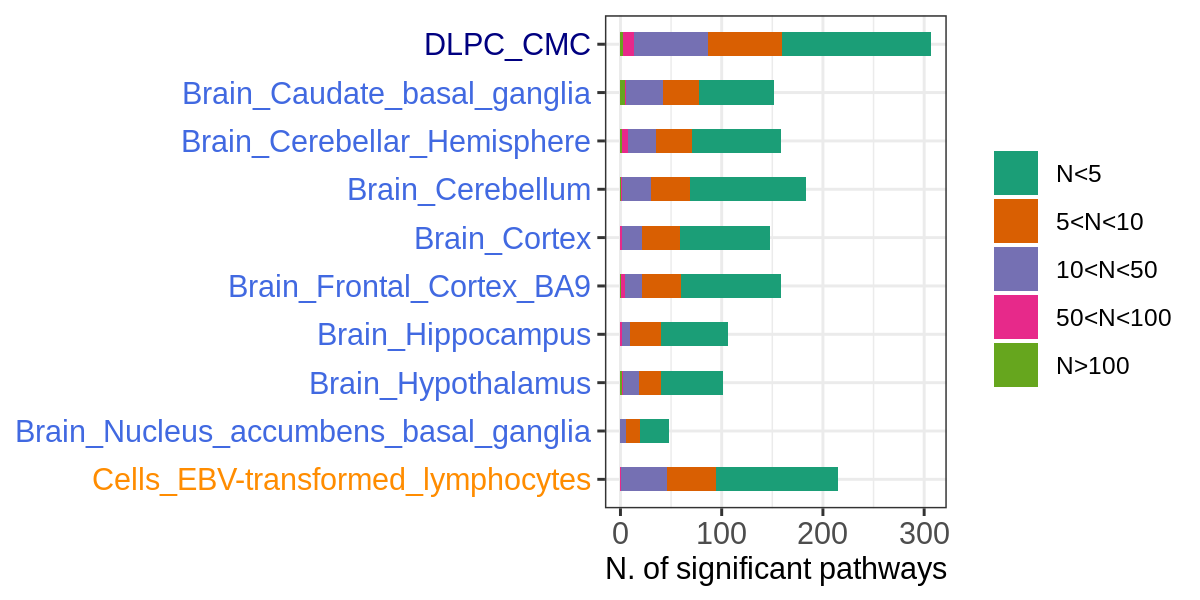

In [17]:
###############################
### Pathway general results ###
###############################

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)

df_path <- path_complete
df_path <- df_path %>% 
    dplyr::mutate(ngenes_binned = dplyr::case_when(ngenes_tscore <5 ~ "N<5", 
                                     ngenes_tscore <10 & ngenes_tscore>=5 ~ "5<N<10", 
                                     ngenes_tscore <50 & ngenes_tscore>=10 ~ "10<N<50", 
                                     ngenes_tscore <100 & ngenes_tscore>=50 ~ "50<N<100", 
                                     ngenes_tscore>=100 ~ "N>100"), .after = ngenes_tscore)
df_path$ngenes_binned <- factor(df_path$ngenes_binned, levels = c("N<5","5<N<10", "10<N<50", "50<N<100", "N>100"))

table(df_path$type_path)

df_table <- as.data.frame(table(df_path$tissue, df_path$ngenes_binned))
df_table$Var1 <- factor(df_table$Var1, levels = rev(tissues)) 
color_tissues_SCZ <- color_tissues$color[match(tissues, color_tissues$tissues)]


pl_bar <- ggplot(data = df_table, mapping = aes(x = Var1, y = Freq, fill = Var2))+
  geom_bar(stat = 'identity', alpha = 1, width = 0.5)+
  theme_bw()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.text.y = element_text(colour = rev(color_tissues_SCZ), size = 11), 
        axis.text.x = element_text(angle = 0, size = 11),
        axis.title.y = element_blank(), strip.text.x = element_text(size = 13))+
  scale_fill_brewer(palette = 'Dark2')+
  ylab('N. of significant pathways')+
  coord_flip()

pl_bar

#ggsave(plot = pl_bar, filename = sprintf('%s/n_significant_path_pertissue.png', out_fold), width = 6, height = 3, dpi = 200)
#ggsave(plot = pl_bar, filename = sprintf('%s/n_significant_path_pertissue.pdf', out_fold), width = 6, height = 3)

# how many paths with genes in MHC locus?
genes_in_MHC <- unique(tscore_loci$external_gene_name[tscore_loci$loci_complete == 'chr6:24966792-33748018'])
df_path$genes_in_MHC <- NA
for(i in 1:nrow(df_path)){
    genes_tmp <- strsplit(df_path$genes_path[i], split = '[,]')[[1]]
    df_path$genes_in_MHC[i] <- any( genes_tmp %in% genes_in_MHC)
}

table(df_path$genes_in_MHC, df_path$type_path)
sum(df_path$genes_in_MHC)
df_path %>% dplyr::group_by(tissue) %>% dplyr::summarise(n = sum(genes_in_MHC))


**Pathwy associations:**
- same pathway removed but not redundant
- correction via FDR, for each tissue and database separately
- In total, GO = 1020, Reactom = 376, WikiHuman = 174, CMCgeneset = 8. 647 out of 1578 sign pathways include genes in MHC locus
- Tissues with the majority of associations are DLPC and lymphocytes. For the first, 106 pathways include a gene in MHC.

In [18]:
path_complete[path_complete$path == 'calcium ion transmembrane transport',]

path                                ngenes_tscore ngenes_path
15466 calcium ion transmembrane transport 6             53         
      mean_dev_geno sd_dev_geno mean_test_dev_geno sd_test_dev_geno
15466 0.2390719     0.1498571   0.07266223         0.1022055       
      mean_gene_corr sd_gene_corr Dx_beta    ⋯ Dx_Cochran_pval Dx_model
15466 -0.0001675367  0.03324356   0.07737963 ⋯ 0.2675561       fixed   
      genes_path                                improvement_sign
15466 PKD1L1,SLC25A25,PDE2A,ITPR2,ATP2B1,PKDREJ TRUE            
      tissue                      type_path gene_from_newloci CMC_z CMC_pval
15466 Brain_Cerebellar_Hemisphere GO        PKD1L1            NA    NA      
      replicated
15466 NA


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                                   980                                    316 
pathway P < genes P & genes FDR > 0.05 
                                   282 


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                             0.6210393                              0.2002535 
pathway P < genes P & genes FDR > 0.05 
                             0.1787072 

[1] 1578

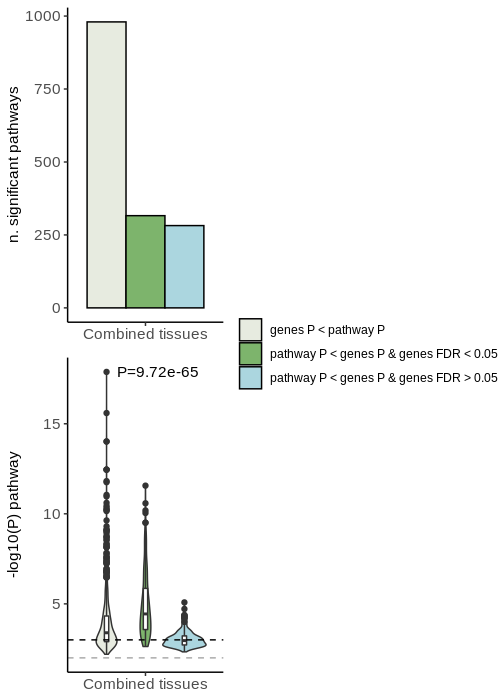

In [19]:
#######################################################################
### number of significant pathways that have better sign than genes ###
#######################################################################
# all tissues combined
options(repr.plot.width = 5, repr.plot.height = 7, repr.plot.res = 100)
pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, 
                           id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
                           fold = out_fold, pheno = pheno, height_pl = 7, width_pl = 5)

pl_npath$pl
table(pl_npath$df$class)
table(pl_npath$df$class)/nrow(pl_npath$df)
nrow(pl_npath$df)
#summary(pl_npath$df$log10p[pl_npath$df$class == 'genes P < pathway P'])
#summary(pl_npath$df$log10p[pl_npath$df$class == 'pathway P < genes P\ngenes FDR < 0.05'])

path_complete_ann <- path_complete
path_complete_ann$class_pathway <- NA
pl_npath$df$class <- as.character(pl_npath$df$class)
for(i in 1:nrow(path_complete_ann)){
  id <- pl_npath$df$path == path_complete_ann$path[i] & pl_npath$df$tissue == path_complete_ann$tissue[i] & pl_npath$df$type_path == path_complete_ann$type_path[i] 
  path_complete_ann$class_pathway[i] <- pl_npath$df$class[id]
}
# save
write.table(path_complete_ann, file = sprintf('%sPathScores_SCZ_annNewLoci_withReplicationCMC_annClass.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

38% (316 + 282) of pathways are more significant than any gene in it. Among which 282 (18% of the total) do not include any significant genes! 

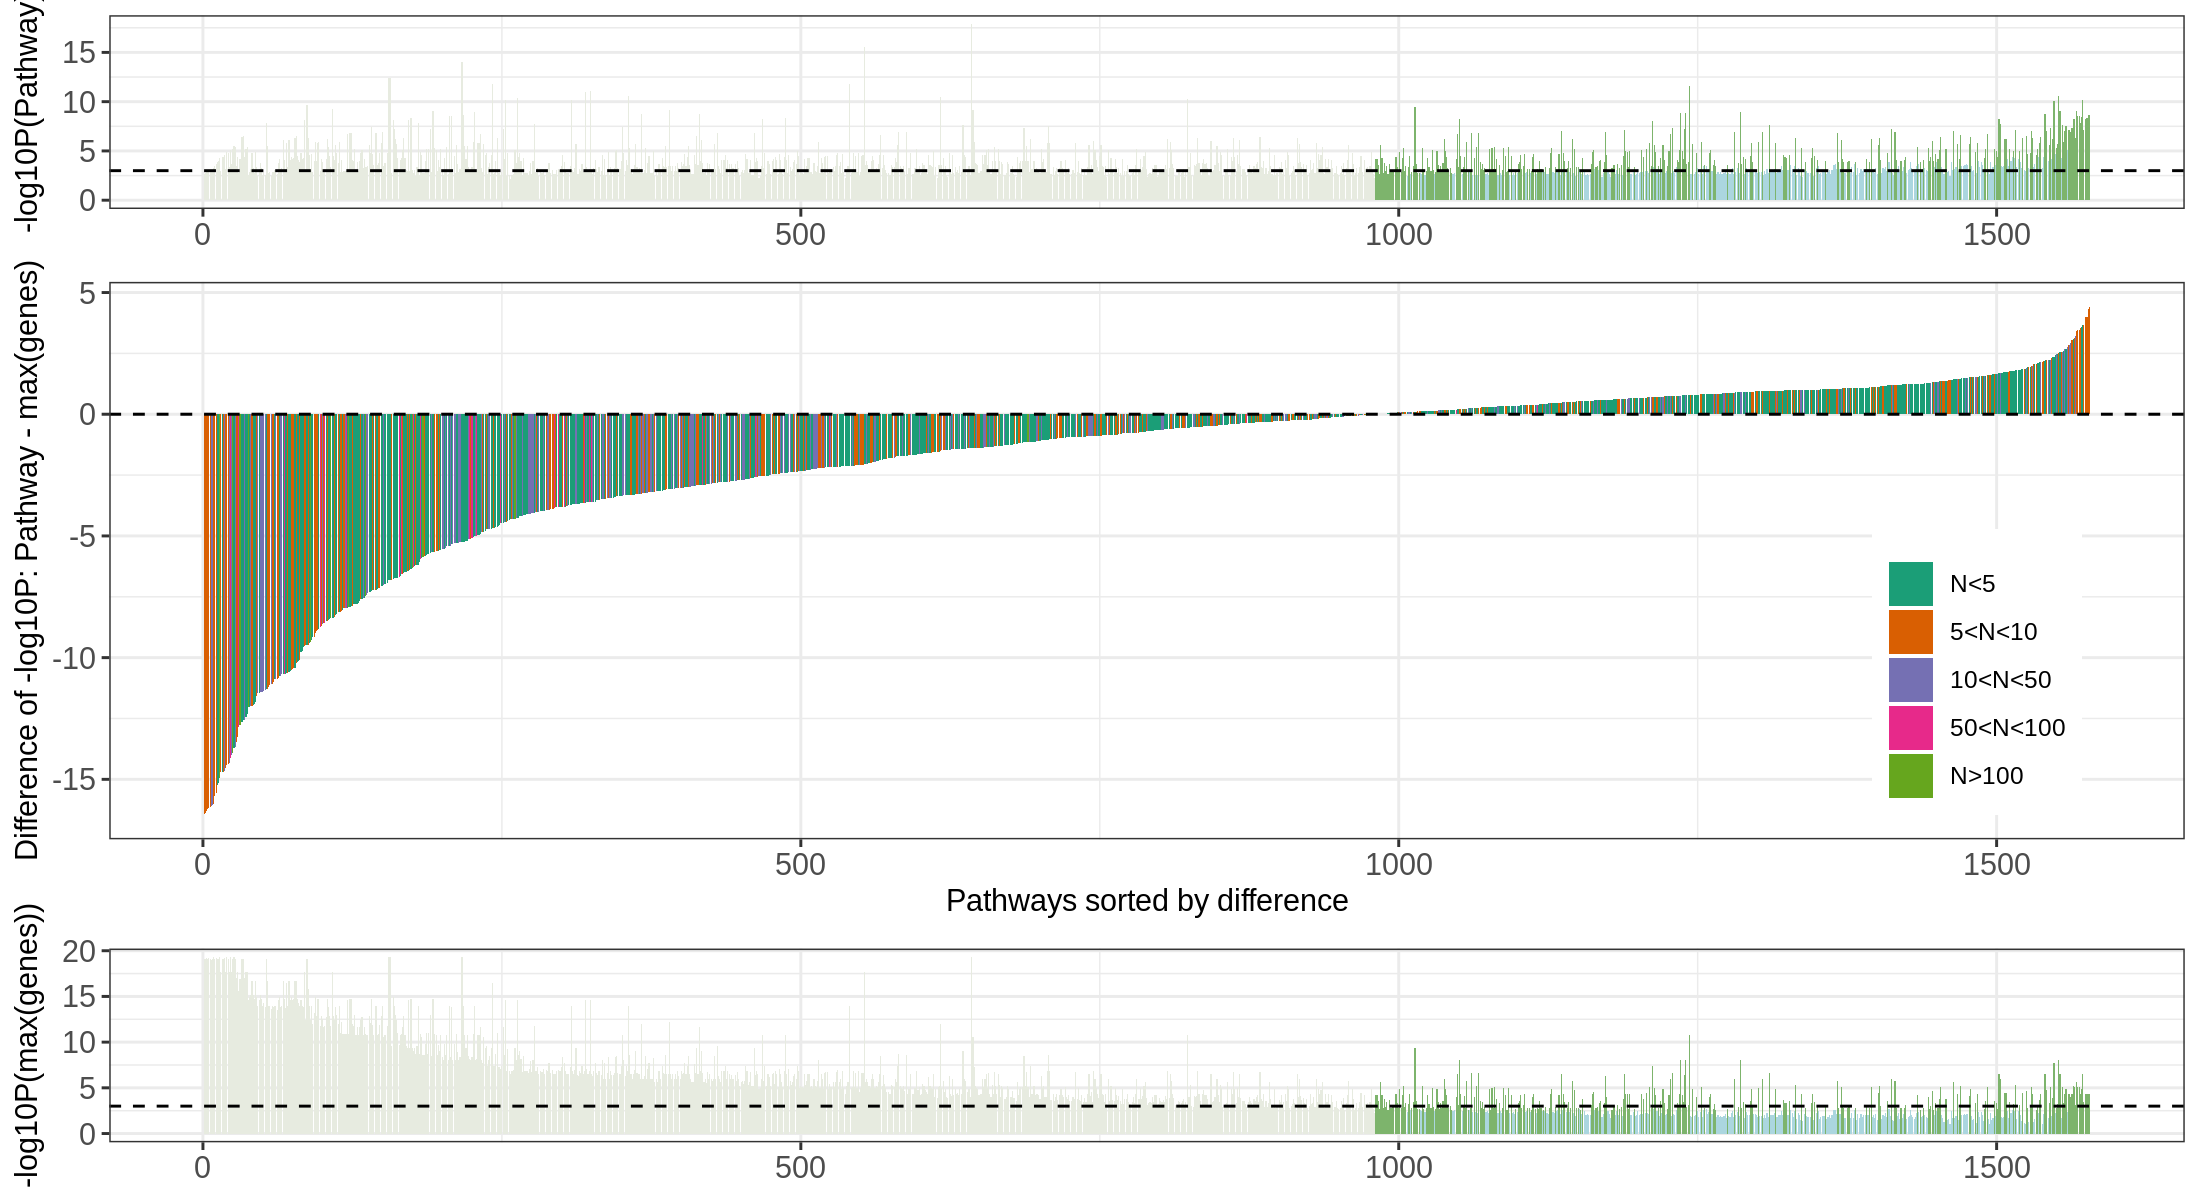

In [20]:
############################
### pathway prioritazion ###
############################

options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 200)

df <- pl_npath$df %>% dplyr::mutate(diff = log10p - max_gene_log10p) %>% 
    dplyr::arrange(diff, max_gene_log10p, log10p) %>%
    dplyr::mutate(index = 1:nrow(path_complete)) %>% 
    dplyr::mutate(ngenes_binned = dplyr::case_when(ngenes_tscore <5 ~ "N<5", 
                                     ngenes_tscore <10 & ngenes_tscore>=5 ~ "5<N<10", 
                                     ngenes_tscore <50 & ngenes_tscore>=10 ~ "10<N<50", 
                                     ngenes_tscore <100 & ngenes_tscore>=50 ~ "50<N<100", 
                                     ngenes_tscore>=100 ~ "N>100"))
df$ngenes_binned <- factor(df$ngenes_binned, levels = c("N<5","5<N<10", "10<N<50", "50<N<100", "N>100"))

pl <- ggplot(data = df, mapping = aes(x = index, y = diff, fill = ngenes_binned))+
  geom_bar(stat = 'identity')+
  geom_hline(yintercept = 0, linetype = 'dashed', size = 0.5)+
  theme_bw()+
  theme(legend.position = c(0.9,0.3), legend.title = element_blank(), 
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
  ylab('Difference of -log10P: Pathway - max(genes)') + 
  xlab('Pathways sorted by difference')+
  scale_fill_brewer(palette = 'Dark2')

pl_log10 <- ggplot(data = df, mapping = aes(x = index, y = log10p, fill = class))+
   geom_bar(stat = 'identity')+
  theme_bw()+
  geom_hline(yintercept = -log10(0.001), linetype = 'dashed', size = 0.5)+
  theme(legend.position = 'none', legend.title = element_blank(), 
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
  ylab('-log10P(Pathway)') + scale_fill_manual(values = c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF'))

pl_maxgenelog10 <- ggplot(data = df, mapping = aes(x = index, y = max_gene_log10p, fill = class))+
  geom_bar(stat = 'identity')+
  theme_bw()+
  geom_hline(yintercept = -log10(0.001), linetype = 'dashed', size = 0.5)+
  theme(legend.position = 'none', legend.title = element_blank(), 
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
  ylab('-log10P(max(genes))') + scale_fill_manual(values = c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF'))


pl_tot <- ggarrange(plotlist = list(pl_log10, pl, pl_maxgenelog10), align = 'v',  ncol = 1, heights = c(0.4, 1, 0.4))
pl_tot
ggsave(plot = pl_tot, filename = sprintf('%s/diff_path_tscores_pvalue.png', out_fold), width = 11, height = 6, dpi = 200)
ggsave(plot = pl_tot, filename = sprintf('%s/diff_path_tscores_pvalue.pdf', out_fold), width = 11, height = 6)


In [21]:
df$id <- paste(df$tissuem, df$type, df$path, sep = '_')
df_path$id <- paste(df_path$tissuem, df_path$type, df_path$path, sep = '_')
df$genes_in_MHC <- df_path$genes_in_MHC[match(df$id, df_path$id)]
table(df$genes_in_MHC, df$class)

       
        genes P < pathway P pathway P < genes P & genes FDR < 0.05
  FALSE                 451                                    193
  TRUE                  529                                    123
       
        pathway P < genes P & genes FDR > 0.05
  FALSE                                    269
  TRUE                                      13

- Indeed, those less significant than a gene in it show a big gap between pathway and gene significance
- mostly coming from genes in MHC locus (529 out of 451+529 pathways with more significant genes).
- The idea is that a single very significant gene "disrupt" and entire pathway. On the other hand small effects concordant in sign aggregate and lead to a cooperative disruption.
- What are these "novel" pathways? Consider only those having genes > 5 or >=3 but coverage >=10%, < 200, total genes < 200, and P <= 0.0001

path                                                                    
1 TCA Cycle and Deficiency of Pyruvate Dehydrogenase complex (PDHc) WP2453
2 Proteasome Degradation WP183                                            
3 Hypothesized Pathways in Pathogenesis of Cardiovascular Disease WP3668  
4 Insulin Signaling WP481                                                 
5 Mitochondrial complex I assembly model OXPHOS system WP4324             
  genes_in_MHC
1 FALSE       
2  TRUE       
3 FALSE       
4  TRUE       
5 FALSE

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


path                                                                    
171 Hypothesized Pathways in Pathogenesis of Cardiovascular Disease WP3668  
189 Insulin Signaling WP481                                                 
237 Mitochondrial complex I assembly model OXPHOS system WP4324             
314 Proteasome Degradation WP183                                            
370 TCA Cycle and Deficiency of Pyruvate Dehydrogenase complex (PDHc) WP2453
    ngenes_tscore ngenes_path mean_dev_geno sd_dev_geno mean_test_dev_geno
171  8             25         0.1248192     0.10520030  0.05760763        
189 48            160         0.1008405     0.06829287  0.04481184        
237 19             56         0.1658211     0.09981018  0.10275308        
314 21             62         0.1614181     0.16415246  0.10783799        
370  8             16         0.1702197     0.13598537  0.07615088        
    sd_test_dev_geno mean_gene_corr sd_gene_corr Dx_beta     ⋯ Dx_pval     
171 0.08061247        0.0003105801  0.03321293    0.07539780 ⋯ 0.0028871691
189 0.05316563        0.0010885429  0.03979991    0.18015851 ⋯ 0.0029654057
237 0.09943259       -0.0003225563  0.03377500   -0.11068613 ⋯ 0.0042709018
314 0.14870848        0.0064808818  0.06505797   -0.11610053 ⋯ 0.0025632033
370 0.08606777       -0.0004750329  0.03470208    0.08538693 ⋯ 0.0007148357
    Dx_qval    Dx_pval_BHcorr Dx_Cochran_stat Dx_Cochran_pval Dx_model
171 0.03076602 0.03558487     43.92867        0.14317741      fixed   
189 0.03076602 0.03558487     55.61996        0.01477659      fixed   
237 0.04197839 0.04855341     47.42850        0.07829300      fixed   
314 0.03076602 0.03558487     33.42294        0.54431558      fixed   
370 0.01779937 0.02058727     40.59877        0.23721813      fixed   
    genes_path                                                                                                                                                                                                                                                                                                    
171 LTBP1,NR2C2,FBN2,RUNX2,MAPK8,LTBP2,FBN1,MAPK3                                                                                                                                                                                                                                                                 
189 PIK3CD,MTOR,MAP3K6,PRKAA2,MAP4K4,MAP3K2,GRB14,PRKCD,EIF4E,GAB1,MAPK9,FLOT1,MAPK13,MAP3K7,ENPP1,MAP3K5,MAP3K4,RPS6KA2,SH2B2,PIK3CG,RAPGEF1,PRKCQ,MAP3K8,MAPK8,PTEN,EHD1,CBL,PIK3C2G,TBC1D4,SOS2,MAP4K5,RHOJ,MAP3K9,SNAP23,MAP2K1,MAP2K5,MAPK3,STX4,CRK,FLOT2,STXBP4,RPS6KB1,GRB2,PIK3C3,PFKL,XBP1,MAPK12,MAPK11
237 NDUFS5,NDUFS2,NDUFAF7,NDUFS1,NDUFA10,ACAD9,NDUFB5,NDUFS4,NDUFA2,NDUFAF4,COA1,NDUFB2,TMEM70,TMEM126B,FOXRED1,NUBPL,NDUFAF1,NDUFV3,NDUFA6                                                                                                                                                                       
314 PSMD4,PSMB4,RPN1,UCHL1,HIST1H2AB,HLA-F,HLA-A,HLA-C,HLA-B,PSMB8,PSMB9,PSMB1,PSMD5,PSMD13,PSMC3,H2AFX,UCHL3,PSMB5,PSMA4,PSMB6,PSMC5                                                                                                                                                                             
370 IDH1,SUCLG2,SDHA,DLD,ACO1,DLST,IDH3A,ACLY                                                                                                                                                                                                                                                                     
    improvement_sign tissue   Dx_pval_BHcorr_overall
171 FALSE            DLPC_CMC 0.04421248            
189 FALSE            DLPC_CMC 0.04446475            
237 FALSE            DLPC_CMC 0.05770166            
314 FALSE            DLPC_CMC 0.04181729            
370  TRUE            DLPC_CMC 0.01892126

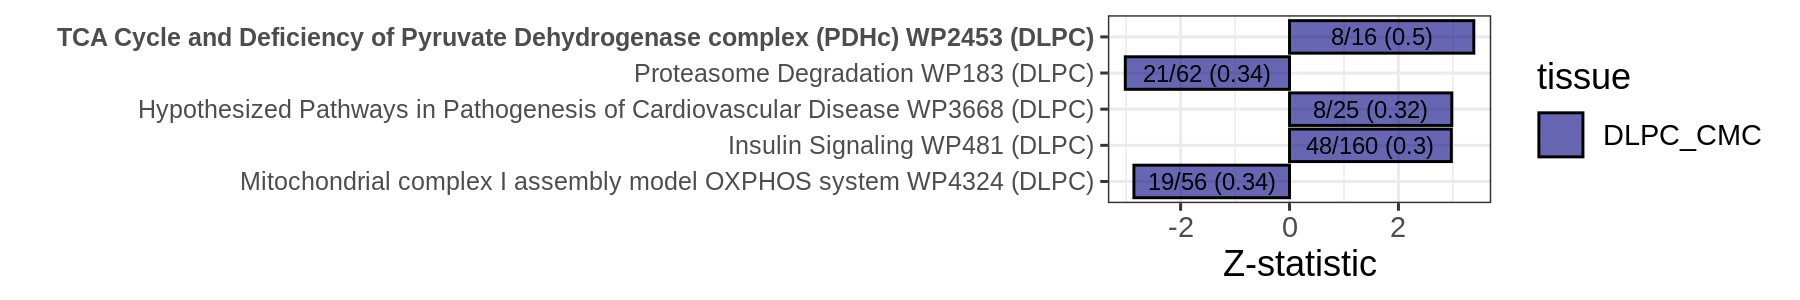

In [48]:
options(repr.plot.width = 9, repr.plot.height = 1.5, repr.plot.res = 200)

path_novel <- df %>% 
     dplyr::filter(path %in% extra_pathway_list) %>% 
     dplyr::arrange(desc(log10p))

path_novel$logpval <-  path_novel$log10p
path_novel$P <-  1/10^(path_novel$log10p)
path_novel$improvement_sign <- F
path_novel$improvement_sign[path_novel$class == 'pathway P < genes P & genes FDR > 0.05' | path_novel$class == 'pathway P < genes P & genes FDR < 0.05'] <- T
path_novel <- path_novel[!duplicated(path_novel$path),]
path_novel[,c("path","genes_in_MHC")]
# save
pl <- plot_best_path(best_res = path_novel, 
                     color_tissues = color_tissues[color_tissues$tissues %in% path_novel$tissue,], 
                     type_mat = 'path', 
               outFold = sprintf('%sextralist_', out_fold), type_dat = type_dat, 
                     tissues = tissues[tissues %in% path_novel$tissue], height_plot = 1.5, 
                     width_plot = 9, id_pval = ncol(path_novel) -1)
# plot
pl$pl_zstat

pathWiki[pathWiki$path %in% extra_pathway_list & pathWiki$tissue == "DLPC_CMC",]


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”



pathway P < genes P & genes FDR < 0.05 
                                    41 

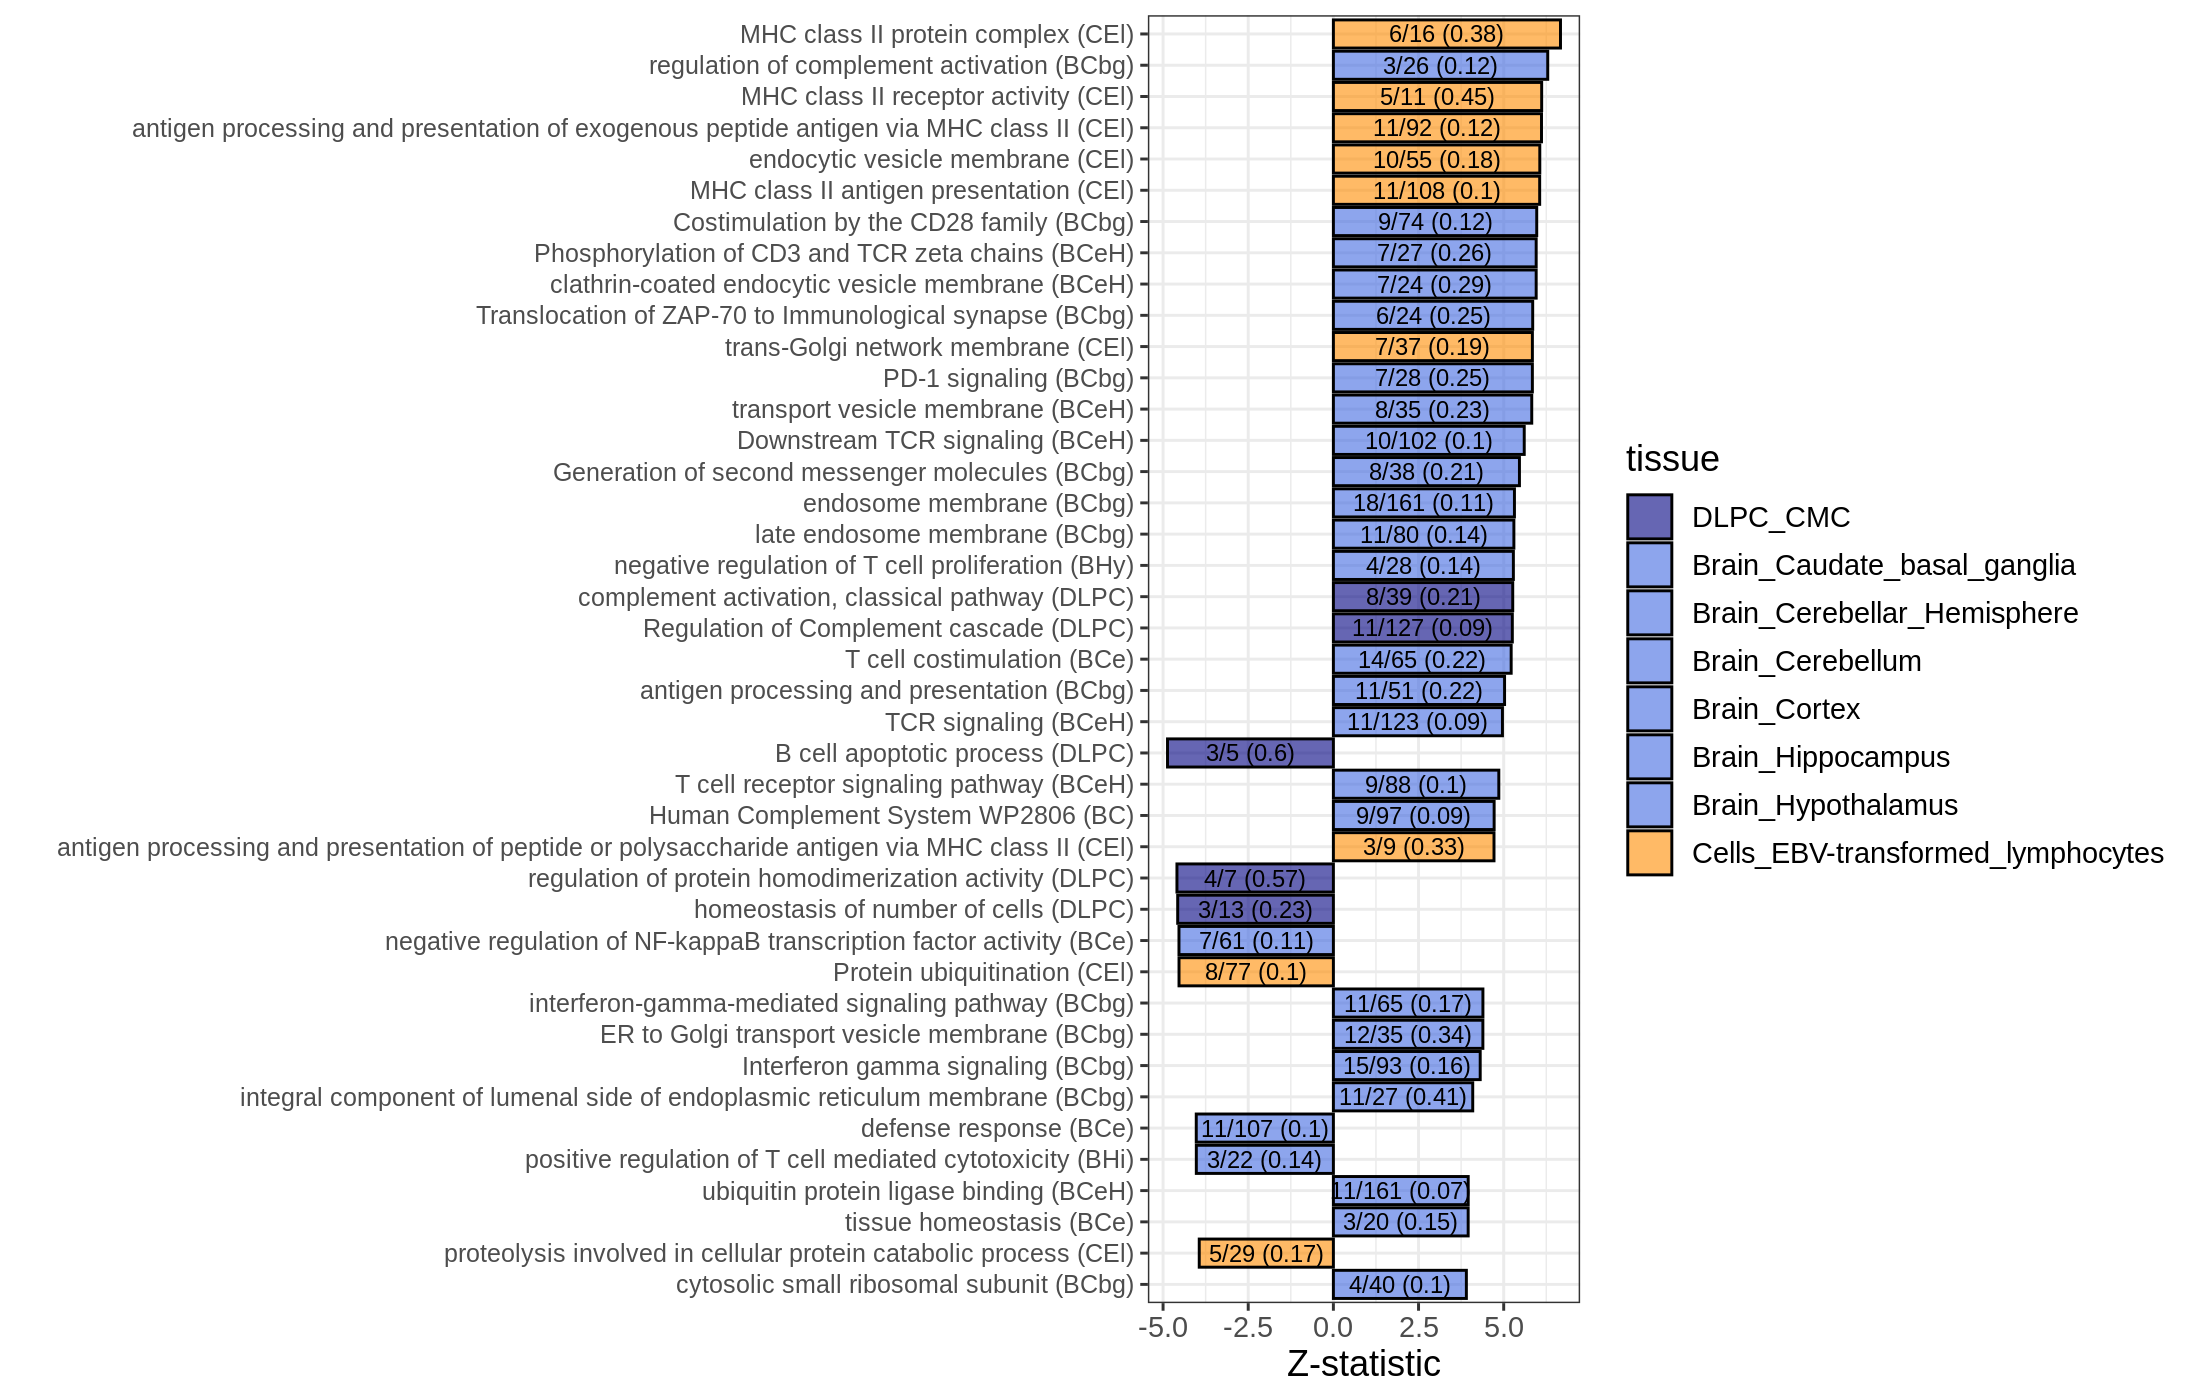

In [17]:
options(repr.plot.width = 11, repr.plot.height = 7, repr.plot.res = 200)

path_novel <- df %>% dplyr::filter(genes_in_MHC, 
                                   ngenes_tscore <= 200 & ngenes_path <=200, 
                            ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3),
                            diff > 0, log10p > 4) %>% 
     dplyr::arrange(desc(log10p))

path_novel$logpval <-  path_novel$log10p
path_novel$P <-  1/10^(path_novel$log10p)
path_novel$improvement_sign <- F
path_novel$improvement_sign[path_novel$class == 'pathway P < genes P & genes FDR > 0.05'] <- T
path_novel <- path_novel[!duplicated(path_novel$path),]

# save
pl <- plot_best_path(best_res = path_novel, 
                     color_tissues = color_tissues[color_tissues$tissues %in% path_novel$tissue,], 
                     type_mat = 'path', 
               outFold = sprintf('%snovel_genesinMHC_', out_fold), type_dat = type_dat, 
                     tissues = tissues[tissues %in% path_novel$tissue], height_plot = 7, 
                     width_plot = 11, id_pval = ncol(path_novel) -1)
# plot
pl$pl_zstat
table(path_novel$class)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”



pathway P < genes P & genes FDR < 0.05 pathway P < genes P & genes FDR > 0.05 
                                    38                                      7 

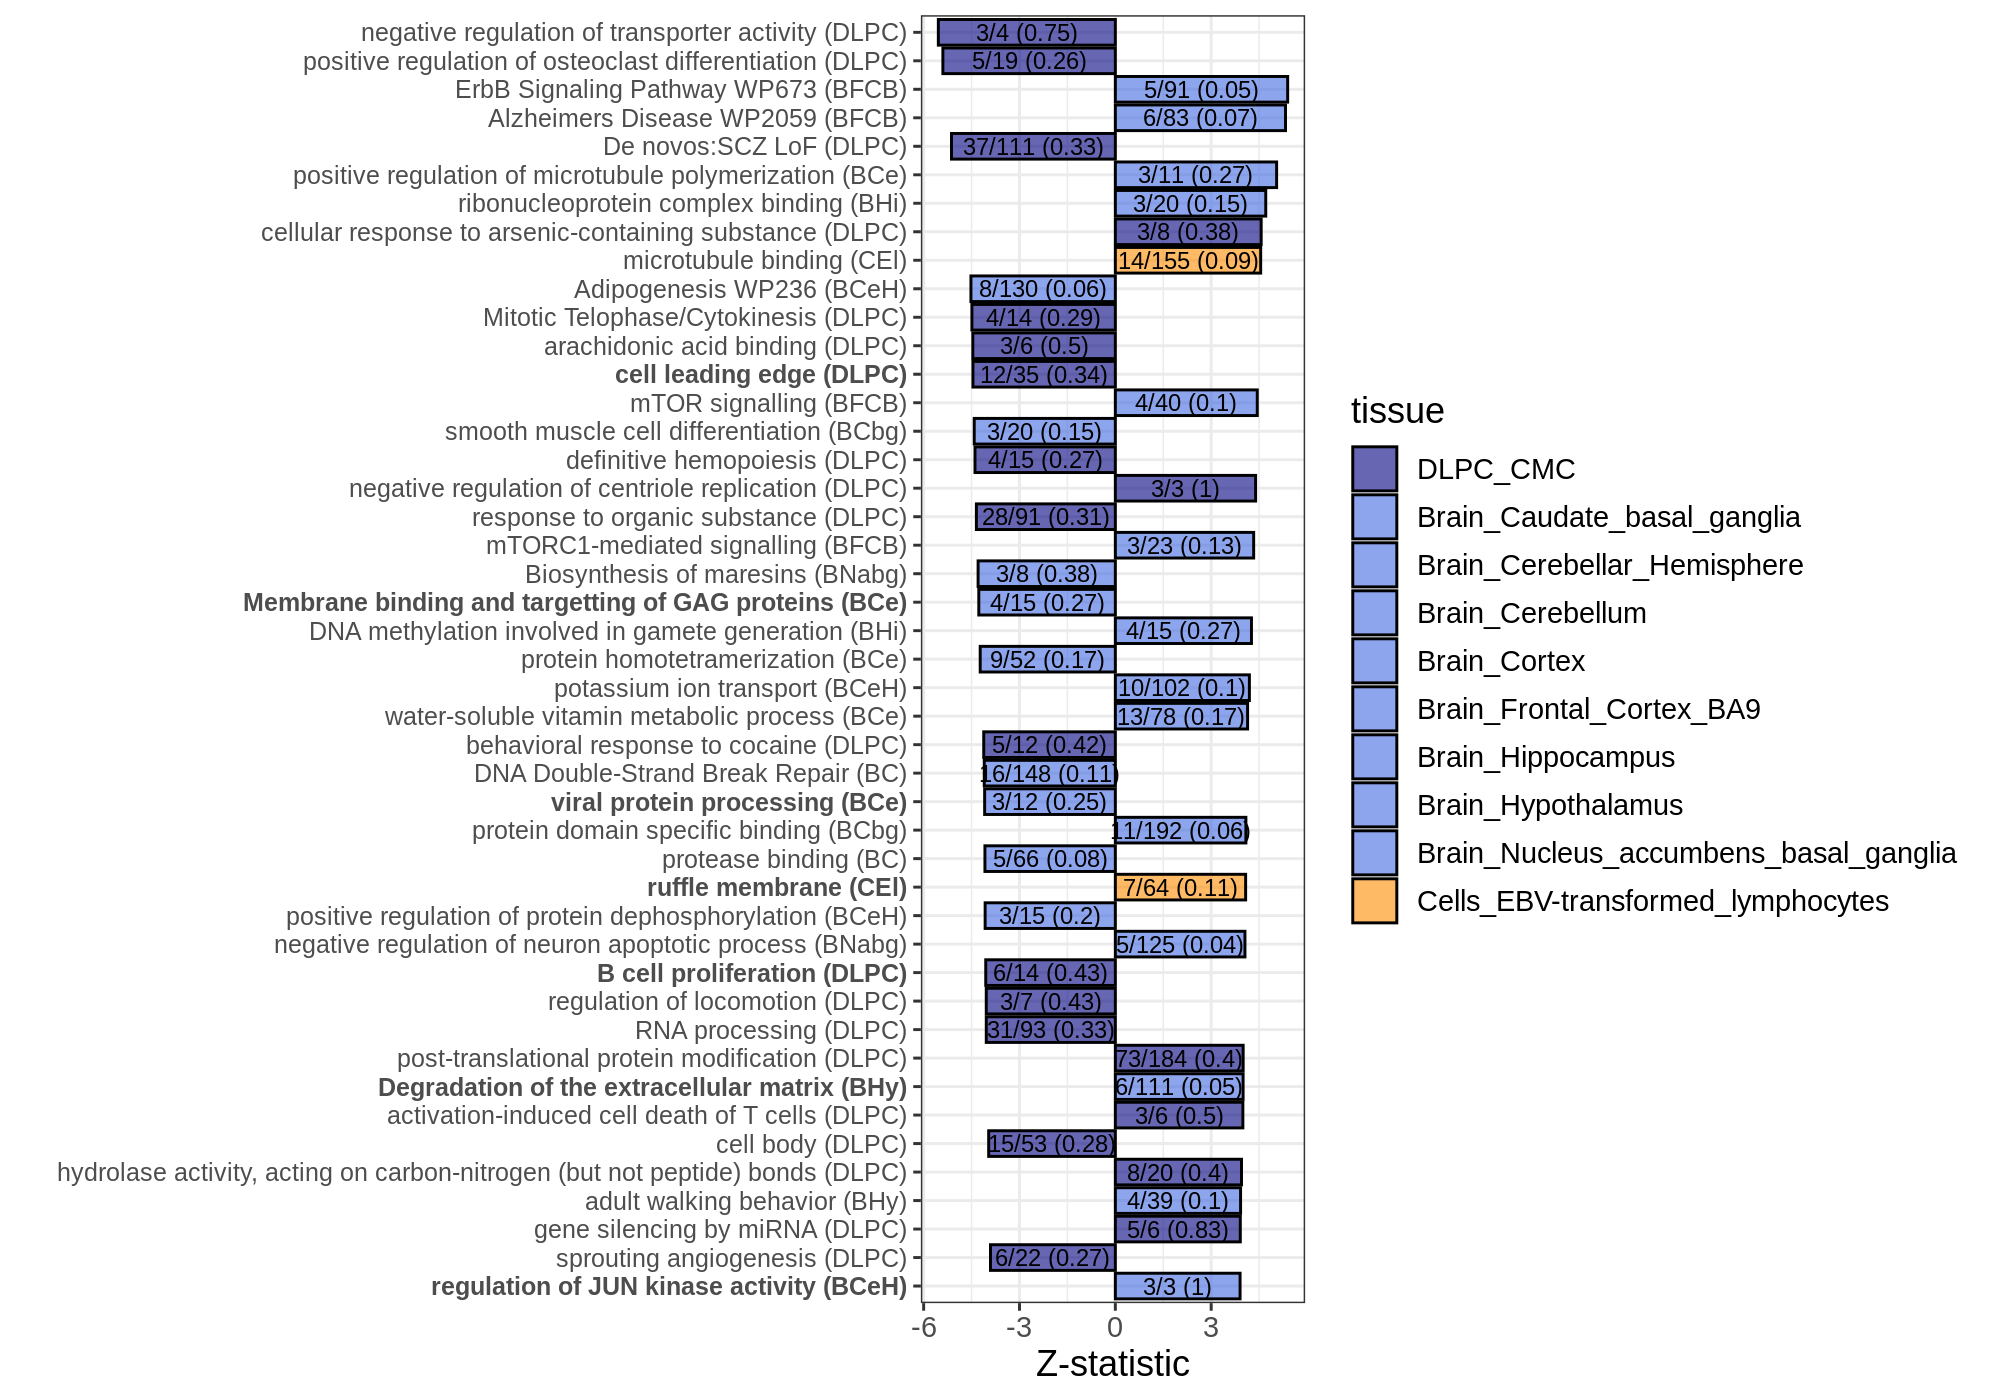

In [18]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

path_novel <- df %>% dplyr::filter(!genes_in_MHC, 
                                   ngenes_tscore <= 200 & ngenes_path <=200, 
                            ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3),
                            diff > 0, log10p > 4) %>% 
     dplyr::arrange(desc(log10p))

path_novel$logpval <-  path_novel$log10p
path_novel$P <-  1/10^(path_novel$log10p)
path_novel$improvement_sign <- F
path_novel$improvement_sign[path_novel$class == 'pathway P < genes P & genes FDR > 0.05'] <- T
path_novel <- path_novel[!duplicated(path_novel$path),]

# save
pl <- plot_best_path(best_res = path_novel, 
                     color_tissues = color_tissues[color_tissues$tissues %in% path_novel$tissue,], 
                     type_mat = 'path', 
               outFold = sprintf('%snovel_genesNOTinMHC_', out_fold), type_dat = type_dat, 
                     tissues = tissues[tissues %in% path_novel$tissue], height_plot = 7, 
                     width_plot = 10, id_pval = ncol(path_novel) -1)
# plot
pl$pl_zstat
table(path_novel$class)

- With this filtering criteria, we get 41 "novel" pathways that include at least 1 gene in MHC and 38+7 that include no genes in MHC. Only 7 include genes not significant at FDR level and only for those pathways without MHC locus gene
- Plot non duplicated pathways (chose most significant tissue)
- For the pathways that are less significant than gene, we hypothesisze that a single gene disrupt the entire pathway but the other genes are not so "collaborative". We show the significant pathways in term of same selection as for the "novel" but group by the most significant gene and chose as exemplar pathway the one with highest coverage.

[1] 125  23

[1] 52

[1] 46 30

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


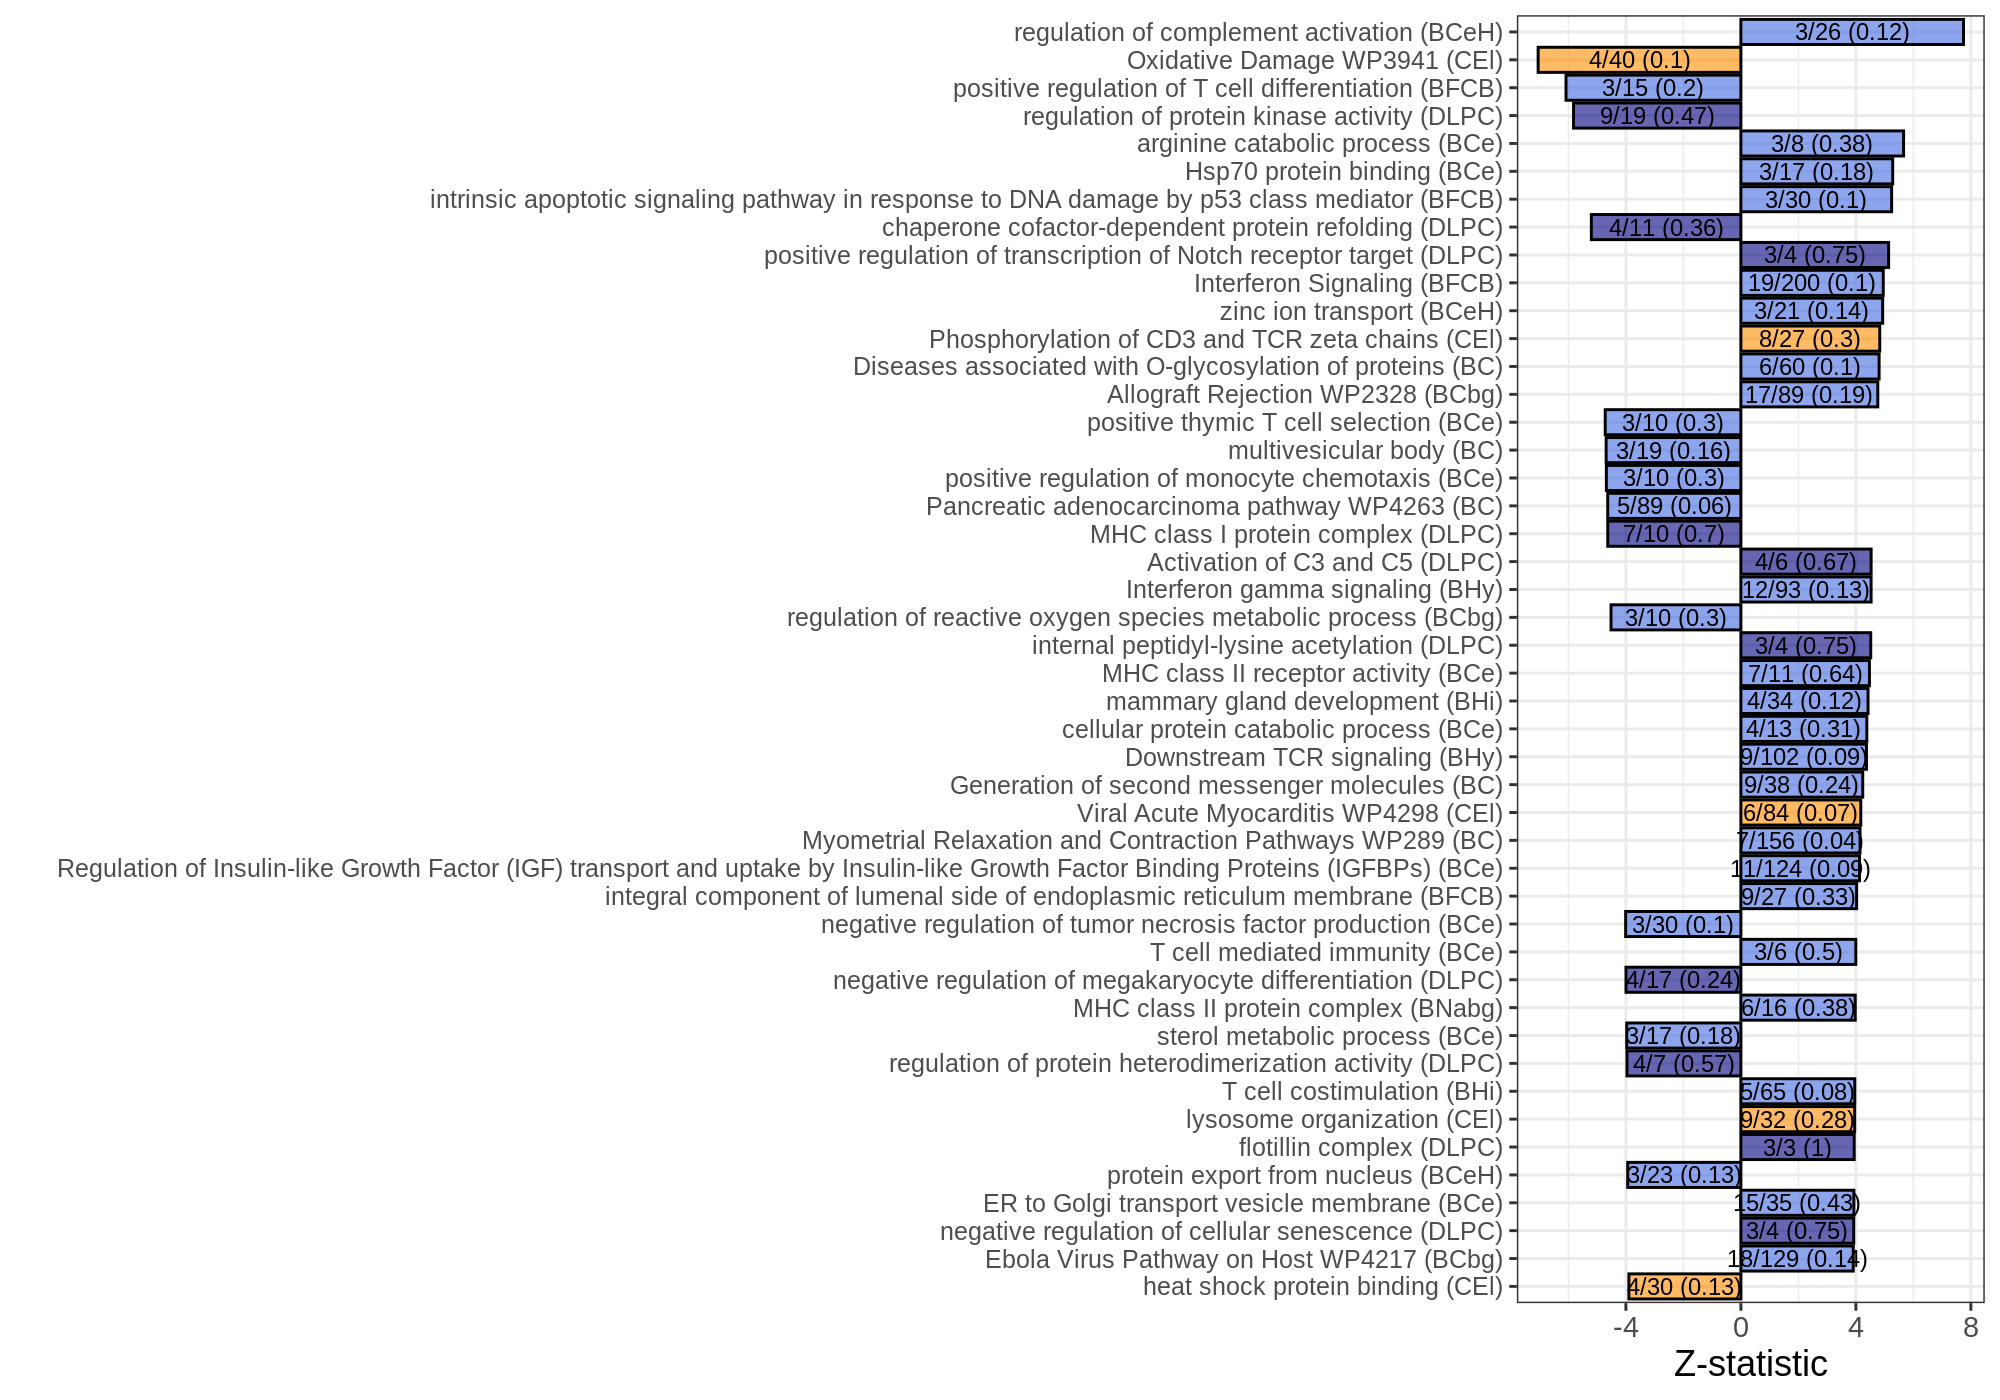

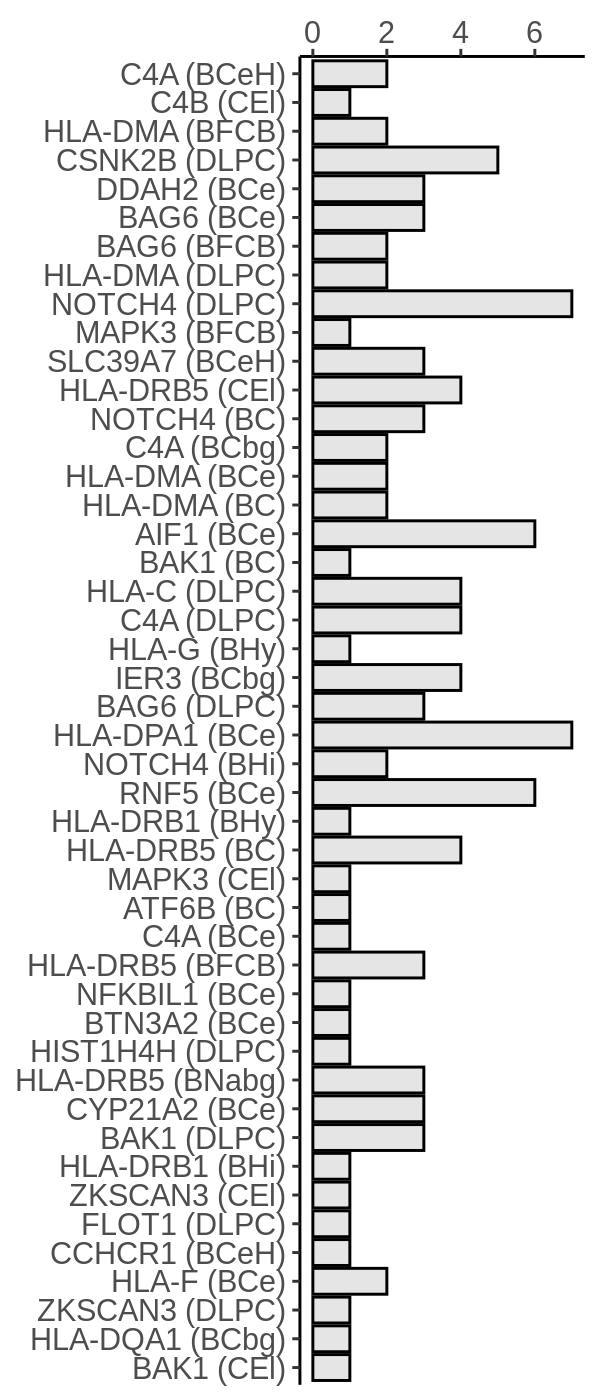

In [19]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

path_known <- df %>% dplyr::filter(genes_in_MHC, 
                                   ngenes_tscore <= 200 & ngenes_path <=200, 
                                   ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3),
                                   diff < 0, log10p > 4) %>% 
    dplyr::arrange(desc(log10p))

dim(path_known)

path_known$logpval <-  path_known$log10p
path_known$best_gene <- NA
path_known$best_gene_tissue <- NA
path_known$name <- paste(path_known$path, path_known$tissue, sep = '_')

convert_name <- function(t){
    
  out <- paste0(sapply(strsplit(t, split = '[_]')[[1]], 
                                function(y) substr(y, start = 1, stop = 1)), collapse = '')
  if(t == 'Brain_Hippocampus'){out <- 'BHi'}
  if(t == 'Brain_Hypothalamus'){out <- 'BHy'}
  if(t == 'Brain_Cerebellum'){out  <- 'BCe'}
  if(t == 'Brain_Cerebellar_Hemisphere'){out  <- 'BCeH'}
  if(t == 'DLPC_CMC'){out  <- 'DLPC'}
    
    return(out)
}
# strongest gene association for each pathway:
for(i in 1:nrow(path_known)){

    tmp <- path_complete %>% dplyr::filter(path_complete$type_path == path_known$type_path[i], 
                             path_complete$tissue == path_known$tissue[i], 
                             path_complete$path == path_known$path[i])
    
    genes <- strsplit(tmp$genes_path, split = '[,]')[[1]]

    gene_info <- tscore %>% dplyr::filter(tissue == path_known$tissue[i], external_gene_name %in% genes)
    path_known$best_gene[i] <- gene_info$external_gene_name[which.min(gene_info$Dx_pval)] 
    
    tmp_tissue <- convert_name(path_known$tissue[i])
    
    path_known$best_gene_tissue[i] <- paste0(path_known$best_gene[i], ' (',tmp_tissue,')')
    path_known$best_gene_tissue_c[i] <- paste0(path_known$best_gene[i], ' (',path_known$tissue[i],')')
    
}
length(table(path_known$best_gene_tissue))
names_t <- unique(path_known$best_gene_tissue_c)
genes <- sapply(names_t, function(x) strsplit(x, split = '[ (]')[[1]][1])
names_t <- sapply(names_t, function(x) strsplit(x, split = '[(]')[[1]][2])
names_t <- sapply(names_t, function(x) strsplit(x, split = '[)]')[[1]][1])

# how many non significant pathways have those genes?
df_best_gene <- data.frame(id = unique(path_known$best_gene_tissue),
                           freq = sapply(unique(path_known$best_gene_tissue), 
                                         function(x) sum(path_known$best_gene_tissue == x)), 
                           tissue = unname(names_t), gene = genes, 
                           n_notsign = NA, examplar = NA, coverage = NA)
                  
for(i in 1:nrow(df_best_gene)){
    tmp <- tot_path %>% dplyr::filter(Dx_pval > 0.0001 &  Dx_pval_BHcorr >=0.05, 
                                    ngenes_tscore <= 200 & ngenes_path <=200, 
                                    ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3), 
                                    grepl(df_best_gene$gene[i], genes_path) , tissue == df_best_gene$tissue[i])
    
    df_best_gene$n_notsign[i] <- nrow(tmp)
    best_res <- path_known[path_known$best_gene_tissue == df_best_gene$id[i],]
    id <- which.max(best_res$ngenes_tscore/best_res$ngenes_path)
    df_best_gene$examplar[i] <- best_res$path[id]
    df_best_gene$coverage[i] <- best_res$ngenes_tscore[id]/best_res$ngenes_path[id]
    df_best_gene$zstat[i] <- best_res$zstat[id]
    
}
df_best_gene$name_tot <- paste(df_best_gene$examplar, df_best_gene$tissue, sep = '_')

# filter and plot:
path_known <- path_known[match(df_best_gene$name_tot, path_known$name),]
path_known$npath <- df_best_gene$freq
path_known$P <-  1/10^(path_known$log10p)
path_known <- path_known[order(path_known$P),]        
path_known <- path_known[!duplicated(path_known$path),]
dim(path_known)                           
tissues_tmp <- tissues[tissues %in% unique(path_known$tissue)]
# save
pl <- plot_best_path(best_res = path_known, color_tissues = color_tissues,
                     type_mat = 'path', 
                     outFold = sprintf('%sknown_genesinMHC_', out_fold), type_dat = type_dat, 
                     tissues = tissues_tmp, height_plot = 7, 
                     width_plot = 14, id_pval = ncol(path_known))
# plot
pl$pl_zstat + theme(legend.position = 'none')

                           
## add annotation:
df_pl <- path_known[, c('best_gene_tissue', 'npath')]
df_pl$n <- 1
df_pl$best_gene_tissue <- factor(df_pl$best_gene_tissue, levels = rev(df_pl$best_gene_tissue))
                           
options(repr.plot.width = 3, repr.plot.height = 7, repr.plot.res = 200)
pl <- ggplot(data = df_pl, mapping = aes(x = best_gene_tissue, y = npath))+
  geom_bar(stat = 'identity', color = 'black', fill = 'grey90')+ 
  theme_classic()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.title.y = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
   scale_y_continuous(position = "right")+
   coord_flip()

pl
ggsave(plot = pl, filename = sprintf('%s/known_genesinMHC_barplot_geneAnn.png', out_fold), width = 3, height = 7, dpi = 200)
ggsave(plot = pl, filename = sprintf('%s/known_genesinMHC_barplot_geneAnn.pdf', out_fold), width = 3, height = 7)
                           

[1] 47 23

[1] 29

[1] 23 30

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


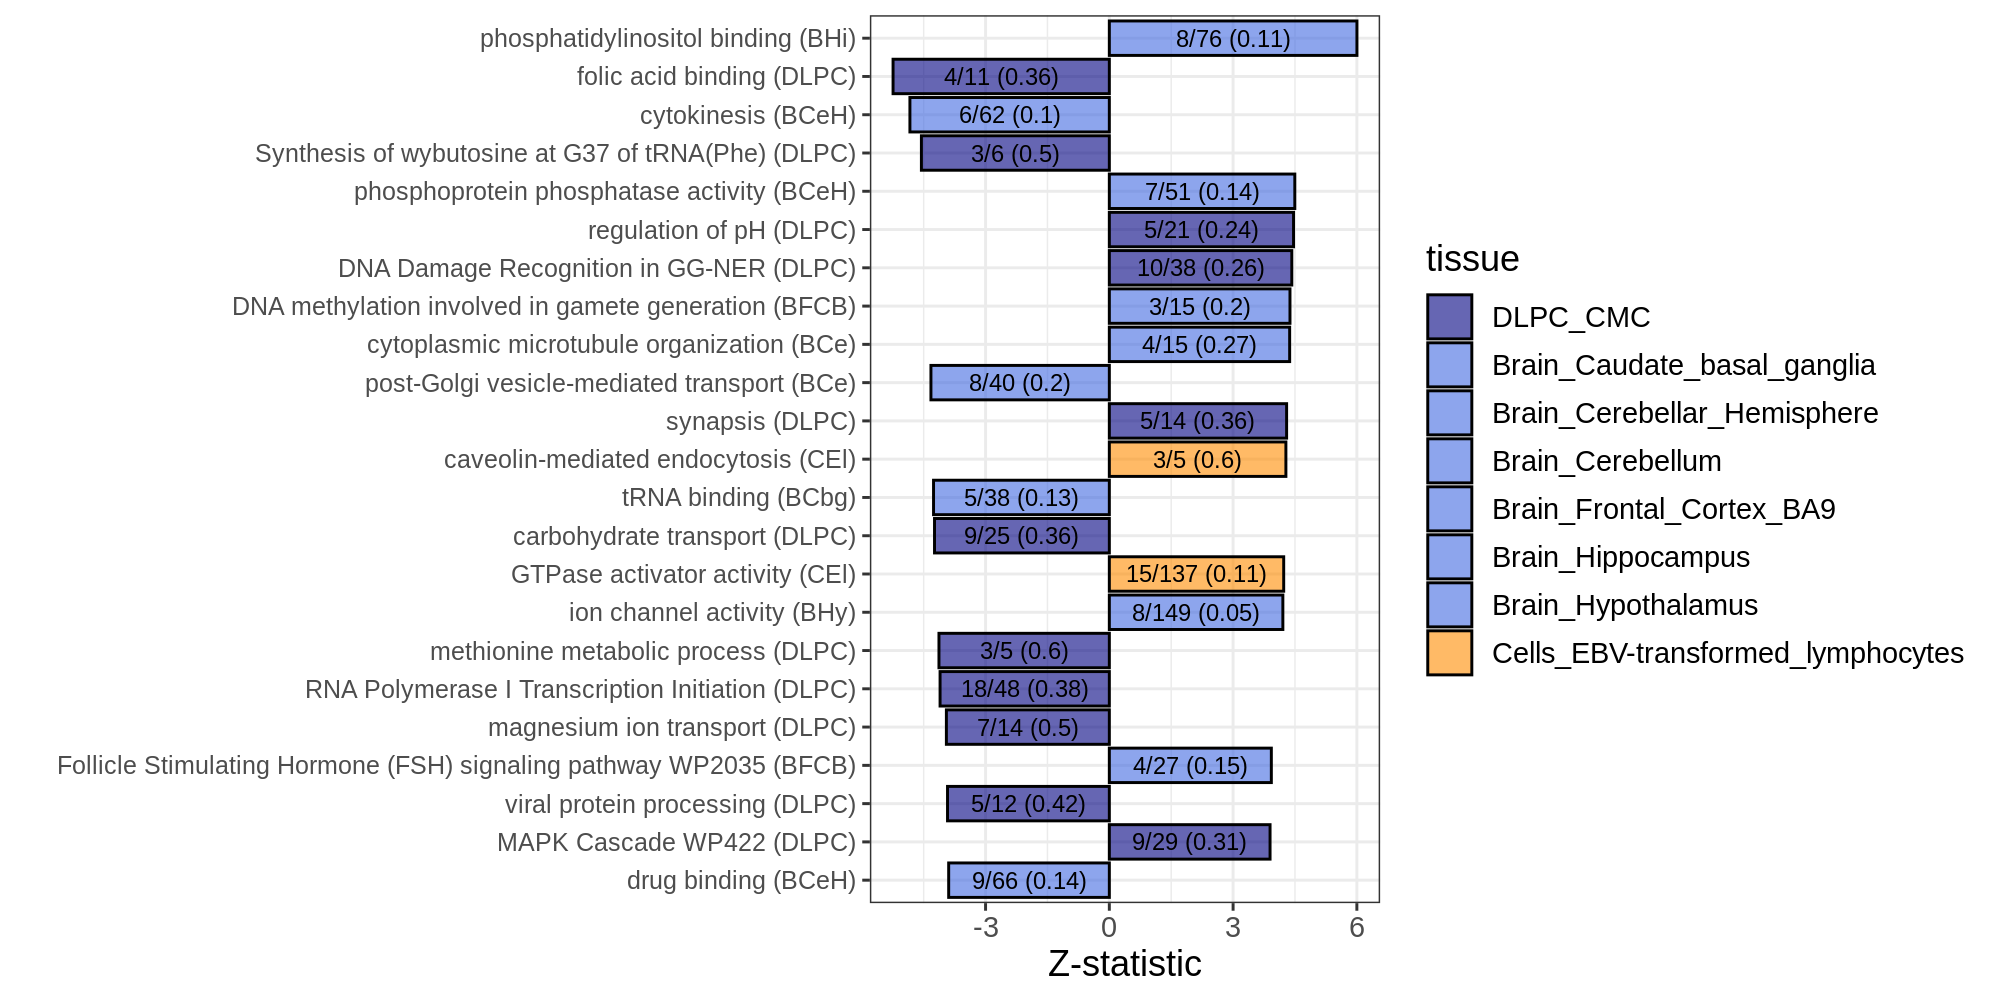

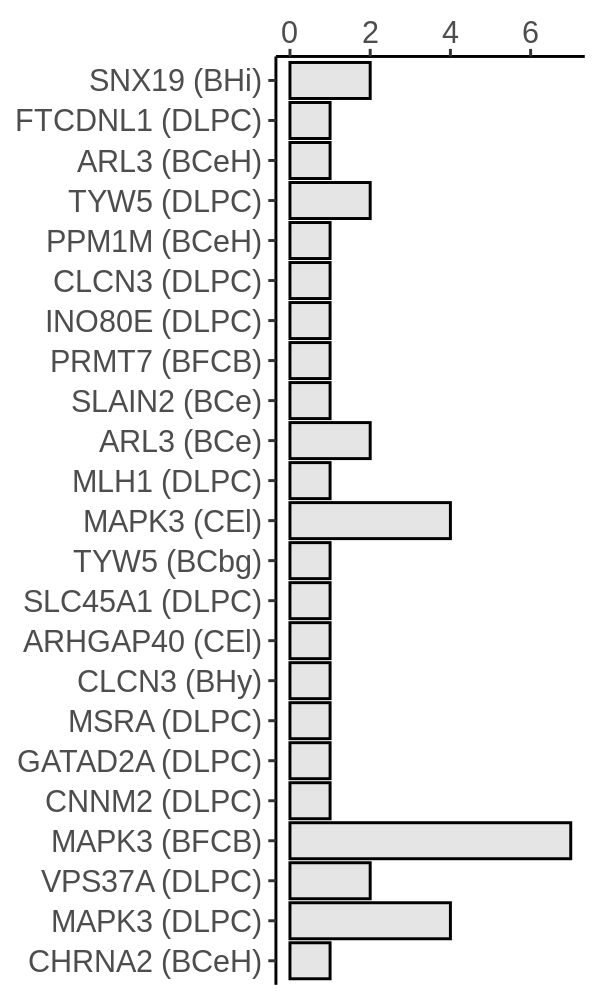

In [20]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

path_known <- df %>% dplyr::filter(!genes_in_MHC, 
                                   ngenes_tscore <= 200 & ngenes_path <=200, 
                                   ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3),
                                   diff < 0, log10p > 4) %>% 
    dplyr::arrange(desc(log10p))

dim(path_known)

path_known$logpval <-  path_known$log10p
path_known$best_gene <- NA
path_known$best_gene_tissue <- NA
path_known$name <- paste(path_known$path, path_known$tissue, sep = '_')

convert_name <- function(t){
    
  out <- paste0(sapply(strsplit(t, split = '[_]')[[1]], 
                                function(y) substr(y, start = 1, stop = 1)), collapse = '')
  if(t == 'Brain_Hippocampus'){out <- 'BHi'}
  if(t == 'Brain_Hypothalamus'){out <- 'BHy'}
  if(t == 'Brain_Cerebellum'){out  <- 'BCe'}
  if(t == 'Brain_Cerebellar_Hemisphere'){out  <- 'BCeH'}
  if(t == 'DLPC_CMC'){out  <- 'DLPC'}
    
    return(out)
}
# strongest gene association for each pathway:
for(i in 1:nrow(path_known)){

    tmp <- path_complete %>% dplyr::filter(path_complete$type_path == path_known$type_path[i], 
                             path_complete$tissue == path_known$tissue[i], 
                             path_complete$path == path_known$path[i])
    
    genes <- strsplit(tmp$genes_path, split = '[,]')[[1]]

    gene_info <- tscore %>% dplyr::filter(tissue == path_known$tissue[i], external_gene_name %in% genes)
    path_known$best_gene[i] <- gene_info$external_gene_name[which.min(gene_info$Dx_pval)] 
    
    tmp_tissue <- convert_name(path_known$tissue[i])
    
    path_known$best_gene_tissue[i] <- paste0(path_known$best_gene[i], ' (',tmp_tissue,')')
    path_known$best_gene_tissue_c[i] <- paste0(path_known$best_gene[i], ' (',path_known$tissue[i],')')
    
}
length(table(path_known$best_gene_tissue))
names_t <- unique(path_known$best_gene_tissue_c)
genes <- sapply(names_t, function(x) strsplit(x, split = '[ (]')[[1]][1])
names_t <- sapply(names_t, function(x) strsplit(x, split = '[(]')[[1]][2])
names_t <- sapply(names_t, function(x) strsplit(x, split = '[)]')[[1]][1])

# how many non significant pathways have those genes?
df_best_gene <- data.frame(id = unique(path_known$best_gene_tissue),
                           freq = sapply(unique(path_known$best_gene_tissue), 
                                         function(x) sum(path_known$best_gene_tissue == x)), 
                           tissue = unname(names_t), gene = genes, 
                           n_notsign = NA, examplar = NA, coverage = NA)
                  
for(i in 1:nrow(df_best_gene)){
    tmp <- tot_path %>% dplyr::filter(Dx_pval > 0.0001 &  Dx_pval_BHcorr >=0.05, 
                                    ngenes_tscore <= 200 & ngenes_path <=200, 
                                    ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3), 
                                    grepl(df_best_gene$gene[i], genes_path) , tissue == df_best_gene$tissue[i])
    
    df_best_gene$n_notsign[i] <- nrow(tmp)
    best_res <- path_known[path_known$best_gene_tissue == df_best_gene$id[i],]
    id <- which.max(best_res$ngenes_tscore/best_res$ngenes_path)
    df_best_gene$examplar[i] <- best_res$path[id]
    df_best_gene$coverage[i] <- best_res$ngenes_tscore[id]/best_res$ngenes_path[id]
    df_best_gene$zstat[i] <- best_res$zstat[id]
    
}
df_best_gene$name_tot <- paste(df_best_gene$examplar, df_best_gene$tissue, sep = '_')

# filter and plot:
path_known <- path_known[match(df_best_gene$name_tot, path_known$name),]
path_known$npath <- df_best_gene$freq
path_known$P <-  1/10^(path_known$log10p)
path_known <- path_known[order(path_known$P),]        
path_known <- path_known[!duplicated(path_known$path),]
dim(path_known)                           
tissues_tmp <- tissues[tissues %in% unique(path_known$tissue)]
# save
pl <- plot_best_path(best_res = path_known, color_tissues = color_tissues,
                     type_mat = 'path', 
                     outFold = sprintf('%sknown_genesNOTinMHC_', out_fold), type_dat = type_dat, 
                     tissues = tissues_tmp, height_plot = 5, 
                     width_plot = 10, id_pval = ncol(path_known))
# plot
pl$pl_zstat 

                           
## add annotation:
df_pl <- path_known[, c('best_gene_tissue', 'npath')]
df_pl$n <- 1
df_pl$best_gene_tissue <- factor(df_pl$best_gene_tissue, levels = rev(df_pl$best_gene_tissue))
                           
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 200)
pl <- ggplot(data = df_pl, mapping = aes(x = best_gene_tissue, y = npath))+
  geom_bar(stat = 'identity', color = 'black', fill = 'grey90')+ 
  theme_classic()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.title.y = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
   scale_y_continuous(position = "right")+
   coord_flip()

pl
ggsave(plot = pl, filename = sprintf('%s/known_genesNOTinMHC_barplot_geneAnn.png', out_fold), width = 3, height = 5, dpi = 200)
ggsave(plot = pl, filename = sprintf('%s/known_genesNOTinMHC_barplot_geneAnn.pdf', out_fold), width = 3, height = 5)
                           

- For pathwys less significant than genes: 125 pathways with genes in MHC. This can be collapsed into 52 examplars (using a representative disrupting genes), 46 of which are unique across tissues.
- For pathwys less significant than genes: 47 pathways without genes in MHC. This can be collapsed into 29 examplars (using a representative disrupting genes), 23 of which are unique across tissues.

png 
  2

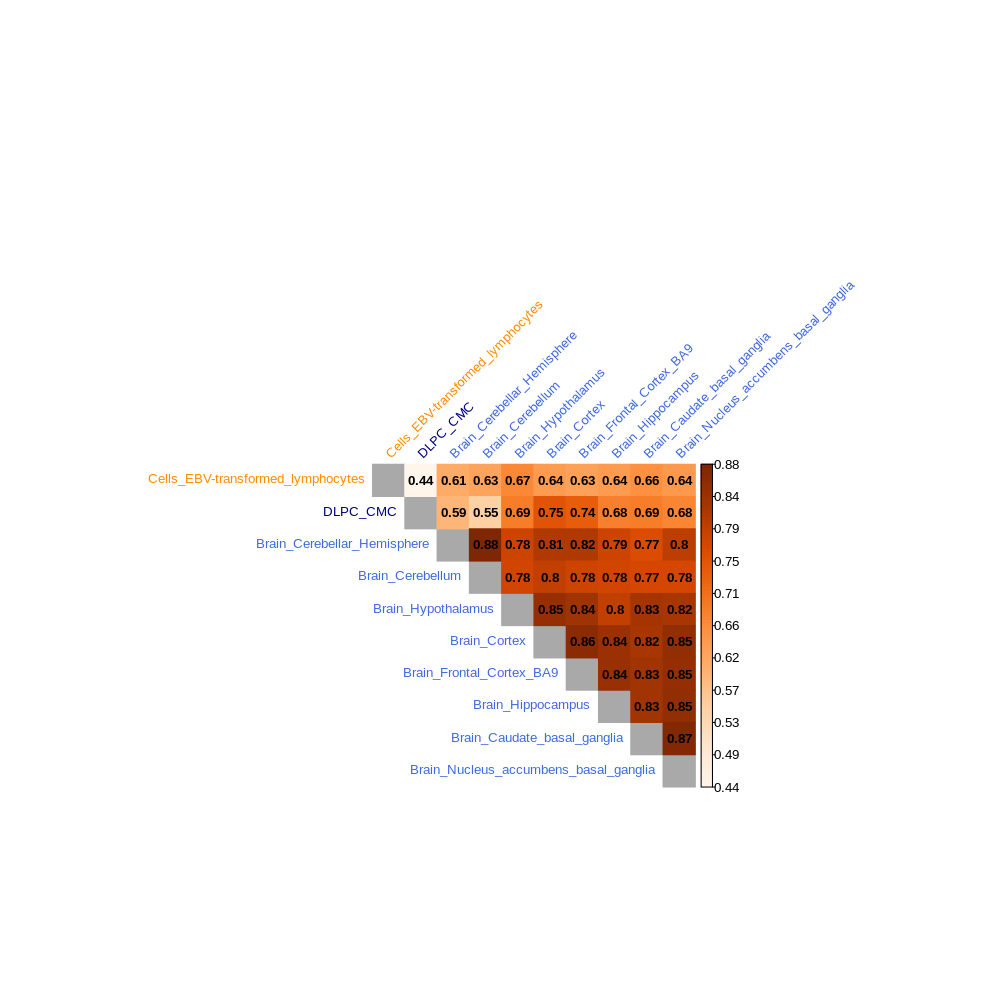

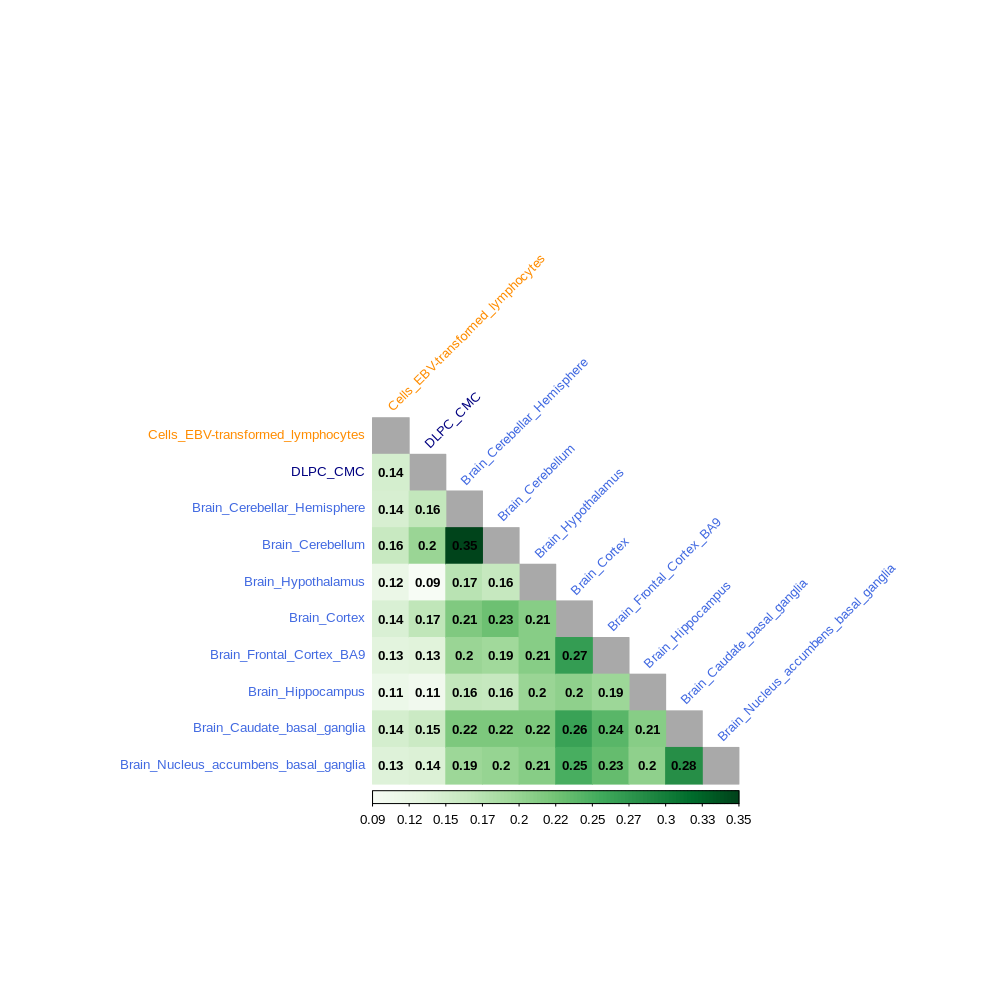

In [21]:
###########################################################
### spearman correlation and Jaccard index shared genes ###
###########################################################
# Fig 3 B
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

tscore_cor <- create_cor(tissues_name = tissues, res = tscore, id_z = 7)
# save
pl_corr(tscore_cor, type_mat = 'tscore', type_dat = type_dat, tissues_name = tissues, df_color = color_tissues, outFold = out_fold, width_pl = 10, height_pl = 7)

# print plots corr + perc
col_val <- colorRampPalette(brewer.pal(9, "Oranges"))
ord <- corrMatOrder(tscore_cor$cor, order = "hclust", hclust.method = "ward.D")
newcolours <- color_tissues$color[match(tissues, color_tissues$tissues)][ord]
diag(tscore_cor$cor) <- NA
corrplot(tscore_cor$cor, type = "upper", order = "hclust", hclust.method = "ward.D", 
        tl.col = newcolours, col = col_val(100), tl.cex = 0.8,
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", 
        na.label = "square", na.label.col = "darkgrey", is.corr = FALSE, 
        number.cex = 0.8)

diag(tscore_cor$perc) <- NA
col_val <- colorRampPalette(brewer.pal(9, "Greens"))(100)
corrplot(tscore_cor$perc[ord, ord], type = "lower", tl.col = newcolours, 
        col = col_val, method = "color", tl.srt = 45, tl.cex = 0.8,
        cl.align.text = "c", addCoef.col = "black", na.label = "square", 
        na.label.col = "darkgrey", is.corr = F, number.cex = 0.8)


[1] "tscore"


tissue n_tot n_sign n_unique n_unique_sign
11 All    26846 1274   12613    768

[1] "tscore not MHC"


tissue n_tot n_sign n_unique n_unique_sign
11 All    26292 979    12434    655

[1] "path-Reactome"


tissue n_tot n_sign n_unique n_unique_sign
11 All    7115  376    1485     255

[1] "path-GO"


tissue n_tot n_sign n_unique n_unique_sign
11 All    19457 1020   5258     692

[1] "path-Wiki Human"


tissue n_tot n_sign n_unique n_unique_sign
11 All    2594  174    445      125

[1] "path-CMC GeneSet"


tissue n_tot n_sign n_unique n_unique_sign
11 All    271   8      271      8

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


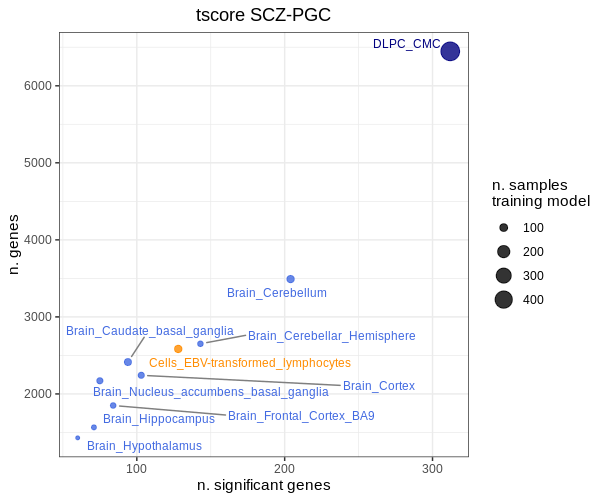

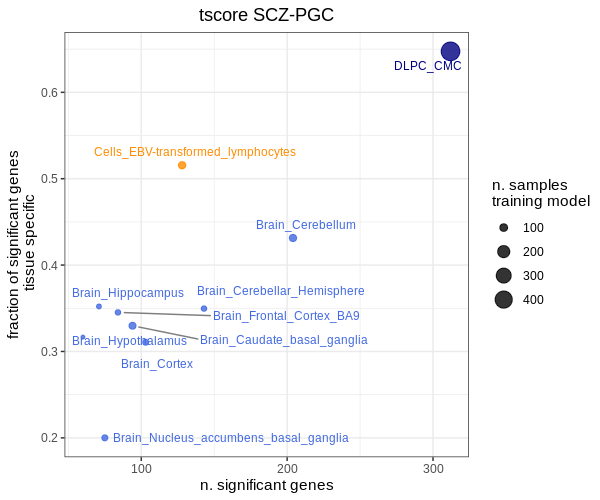

In [22]:
############################################################
### plot number of association per tissue vs specificity ###
############################################################
# Supplementary (to add)
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 100)

tscore_nsign <- creat_dfnsign(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 10)
pathR_nsign <- creat_dfnsign(tissues_name = tissues, res = pathR, id_pval_corr = 15, 
                             pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 15)
pathGO_nsign <- creat_dfnsign(tissues_name = tissues, res = pathGO, id_pval_corr = 17, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 17)

pathwiki_nsign <- creat_dfnsign(tissues_name = tissues, res = pathWiki, id_pval_corr = 15, 
                                                  pval_FDR = pval_FDR, df_color = color_tissues,
                                id_pval_corr_tot = 15)
pathCMC_nsign <- creat_dfnsign(tissues_name = tissues, res = pathCMC, id_pval_corr = 15, 
                                                  pval_FDR = pval_FDR, df_color = color_tissues,
                                id_pval_corr_tot = 15)
tscore_red <- tscore
HLA_reg <- c(26000000, 34000000)
tscore_red <- tscore_red[!(tscore_red$chrom %in% 'chr6' & tscore_red$start_position <=HLA_reg[2] & tscore_red$start_position >= HLA_reg[1]) , ]
tscore_noMHC_nsign <- creat_dfnsign(tissues_name = tissues, res = tscore_red, id_pval_corr = 10, 
                                    pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 10)

print('tscore')
tscore_nsign$table[length(tissues)+1,]
print('tscore not MHC')
tscore_noMHC_nsign$table[length(tissues)+1,]
print('path-Reactome')
pathR_nsign$table[length(tissues)+1,]
print('path-GO')
pathGO_nsign$table[length(tissues)+1,]
print('path-Wiki Human')
pathwiki_nsign$table[length(tissues)+1,]
print('path-CMC GeneSet')
pathCMC_nsign$table[length(tissues)+1,]


# save
pl <- pl_number_function(df = tscore_nsign$plot, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl$ngen
pl$frac


In [27]:
cor(tscore_nsign$plot$ntrain, tscore_nsign$plot$nsign, method = 'spearman')

[1] 0.7805023

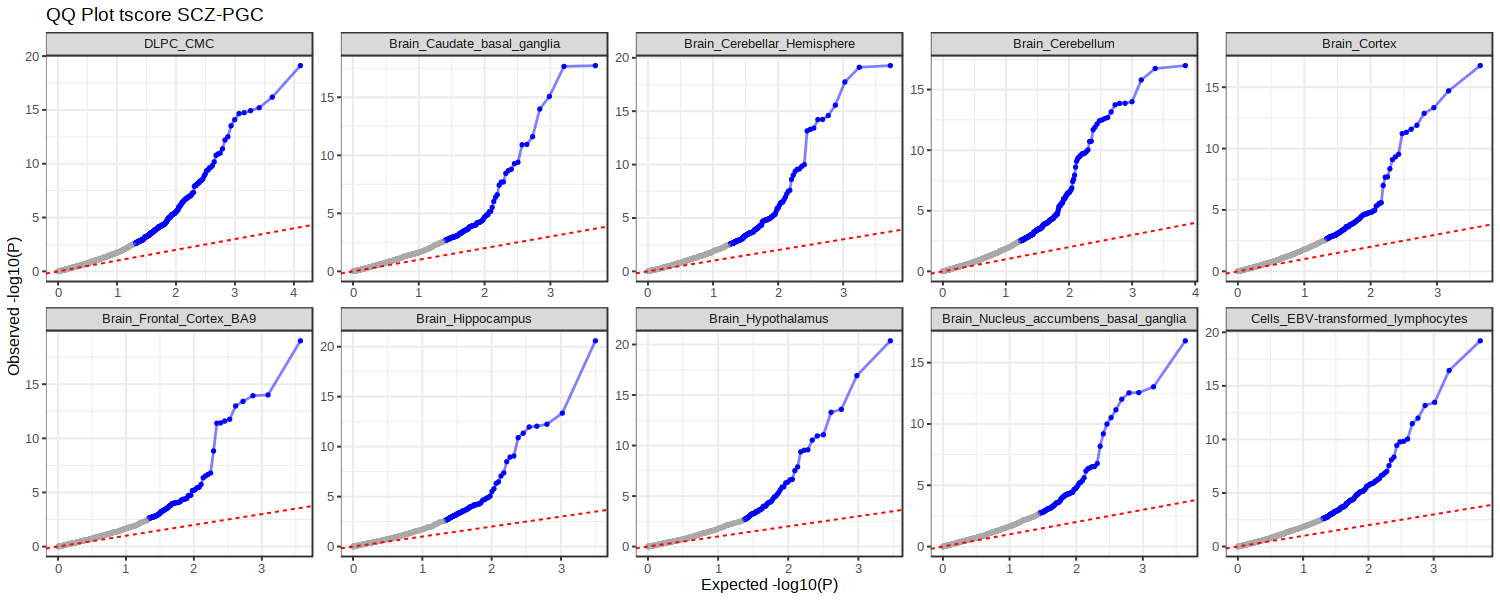

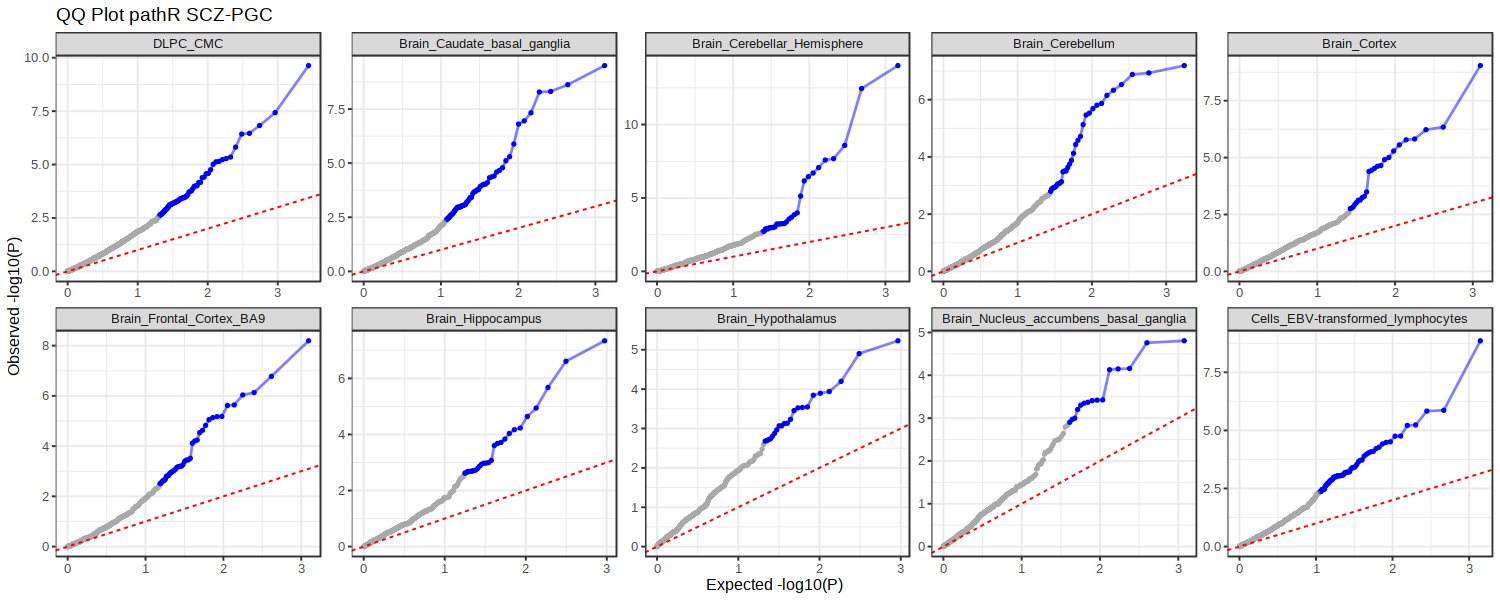

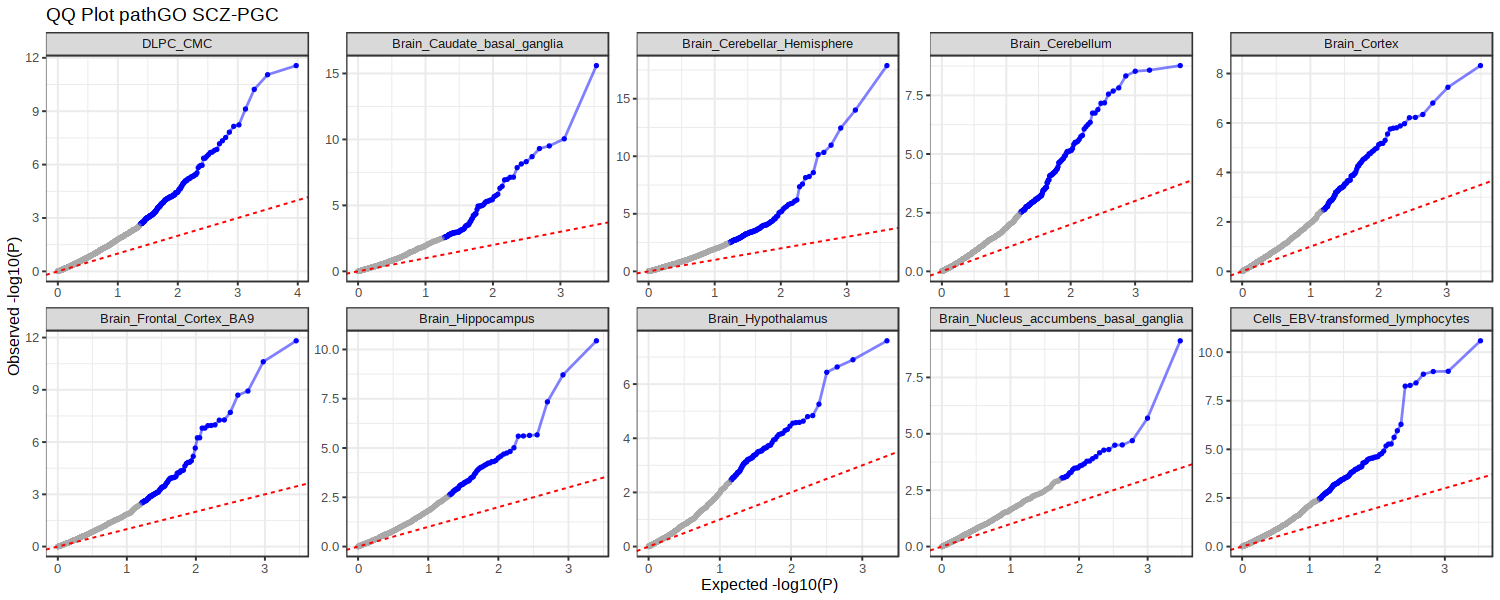

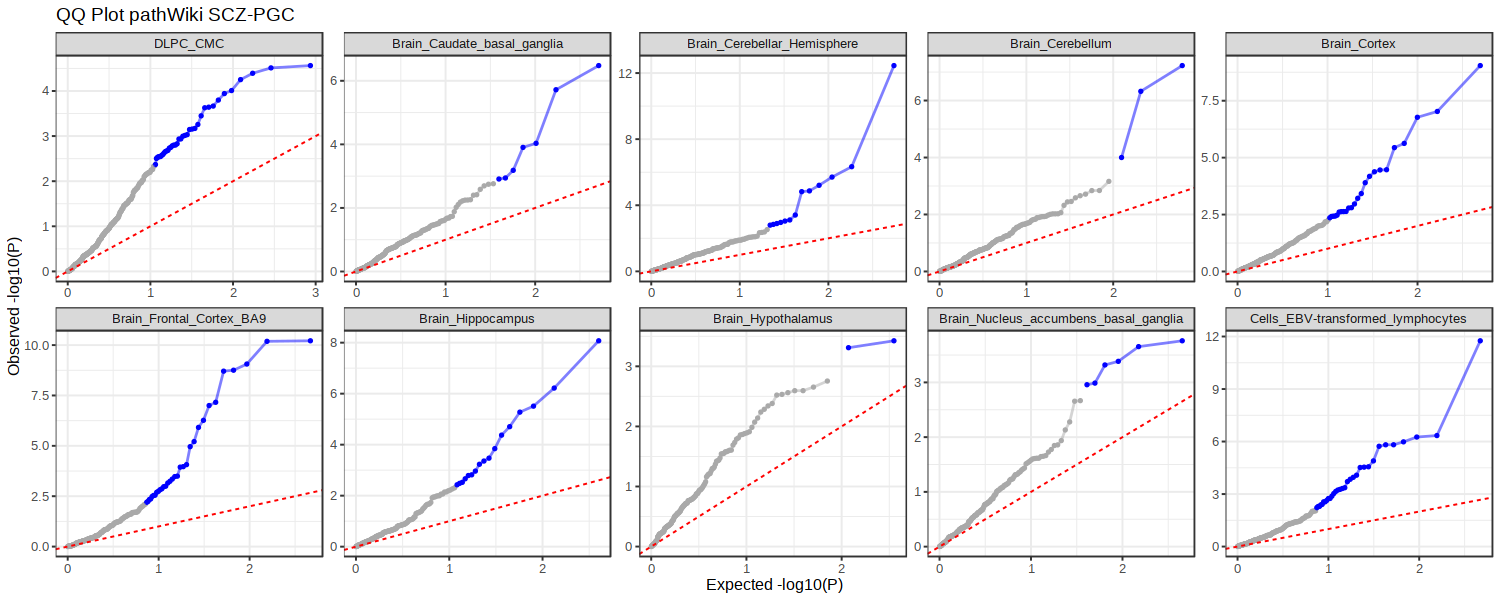

In [16]:
####################################
### plot qq-plot tissue specific ###
####################################
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 100)

# tscore
res <- qq_plot_tissues(data = tscore, color_tissues = color_tissues, id_pval = 8, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'tscore', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path Reactome
res <- qq_plot_tissues(data = pathR, color_tissues = color_tissues, id_pval = 13, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathR', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path GO
res <- qq_plot_tissues(data = pathGO, color_tissues = color_tissues, id_pval = 15, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathGO', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path Wiki
res <- qq_plot_tissues(data = pathWiki, color_tissues = color_tissues, id_pval = 13, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathWiki', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl



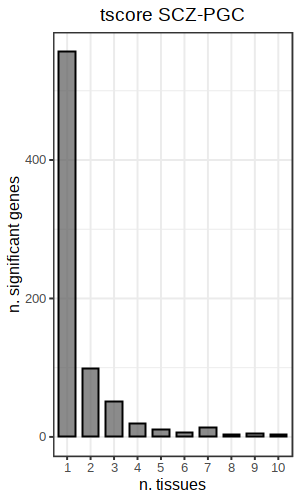

In [17]:
##################################################
### plot number of genes per number of tissues ###
##################################################
# Supplementary (to add)

options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 100)
tscore_nsgin_tissue <- creat_dfnsign_tissueSpec(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                                                pval_FDR = pval_FDR)
# save
pl <- pl_numberSpec_function(df = tscore_nsgin_tissue, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl

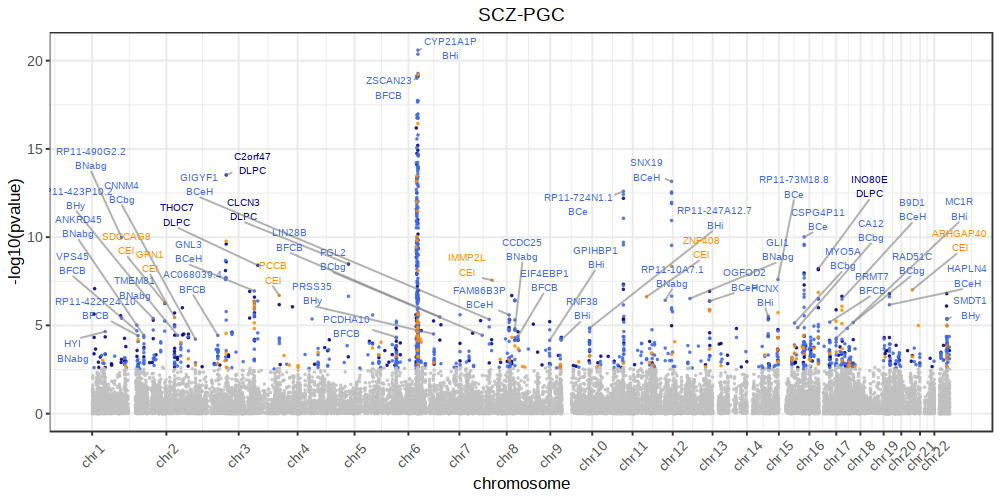

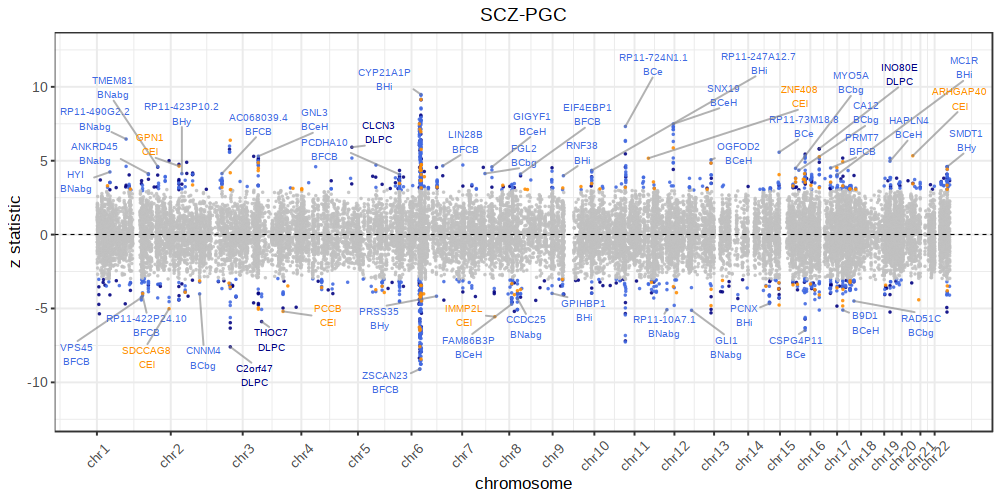

In [18]:
############################
### manhattan plot genes ###
############################
# Fig. 1A
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)

n_sign <- 30
convert_tissue_name <- function(vect_name){
  vect_name[vect_name %in% 'DLPC_CMC'] <- 'DLPC'
  vect_name[vect_name %in% 'Brain_Caudate_basal_ganglia'] <- 'BCbg'
  vect_name[vect_name %in% 'Brain_Cerebellar_Hemisphere'] <- 'BCeH'
  vect_name[vect_name %in% 'Brain_Cerebellum'] <- 'BCe'
  vect_name[vect_name %in% 'Brain_Cortex'] <- 'BC'
  vect_name[vect_name %in% 'Brain_Frontal_Cortex_BA9'] <- 'BFCB'
  vect_name[vect_name %in% 'Brain_Hippocampus'] <- 'BHi'
  vect_name[vect_name %in% 'Brain_Hypothalamus'] <- 'BHy'
  vect_name[vect_name %in% 'Brain_Nucleus_accumbens_basal_ganglia'] <- 'BNabg'
  vect_name[vect_name %in% 'Cells_EBV-transformed_lymphocytes'] <- 'CEl'  
  
  return(vect_name)
}
tissues_short <- convert_tissue_name(tissues)
tscore_short <- tscore 
tscore_short$tissue <- convert_tissue_name(tscore_short$tissue)
color_tissues_short <- color_tissues
color_tissues_short$tissues <- convert_tissue_name(color_tissues_short$tissues)

# for each tissue keep name of the 30 most significant genes
tscore_df <- create_df_manhattan_plot(tissues_name = tissues_short, res = tscore_short, id_pval = 8, 
                                      pval_FDR = pval_FDR, df_color = color_tissues_short, id_name = 2, 
                                      n_sign = n_sign, gene = T)
# include only 1 gene per locus
new_list <- tscore_df$df[tscore_df$df$sign_name == 'yes', ]
dist_mat <- as.matrix(dist(new_list$id_pos, method = 'manhattan'))
keep_t <- new_list$name
# recursevly until no intersection
tmp <- new_list
while(any(dist_mat[upper.tri(dist_mat)] < 3)){
  
  t_list <- apply(dist_mat, 1, function(x) x < 3)
  len_t <- c()
  keep_t <- c()
  for(j in 1:nrow(t_list)){
    tmp_sel <-  new_list[new_list$name %in% tmp$name[t_list[j,]],]
    tmp_sel <- tmp_sel[!tmp_sel$name %in% len_t, ]
    len_t <- unique(c(len_t, tmp_sel$name))
    keep_t <- unique(c(keep_t, tmp_sel$name[which.max(tmp_sel$pval_tr)]))
  }
  
  tmp <- tmp[tmp$name %in% keep_t, ]
  dist_mat <- as.matrix(dist(tmp$id_pos,method = 'manhattan'))
  
}
tscore_df$df$sign_name[tscore_df$df$sign_name == 'yes' & !tscore_df$df$name %in% tmp$name] <- 'no'
tscore_df$df$name[tscore_df$df$sign_name == 'no'] <- ''

# save
pl_tot <- pl_manhattan_function(data_input = tscore_df, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)
# plot
pl_tot$manhattan_pl
pl_tot$zstat_pl
                  
               

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


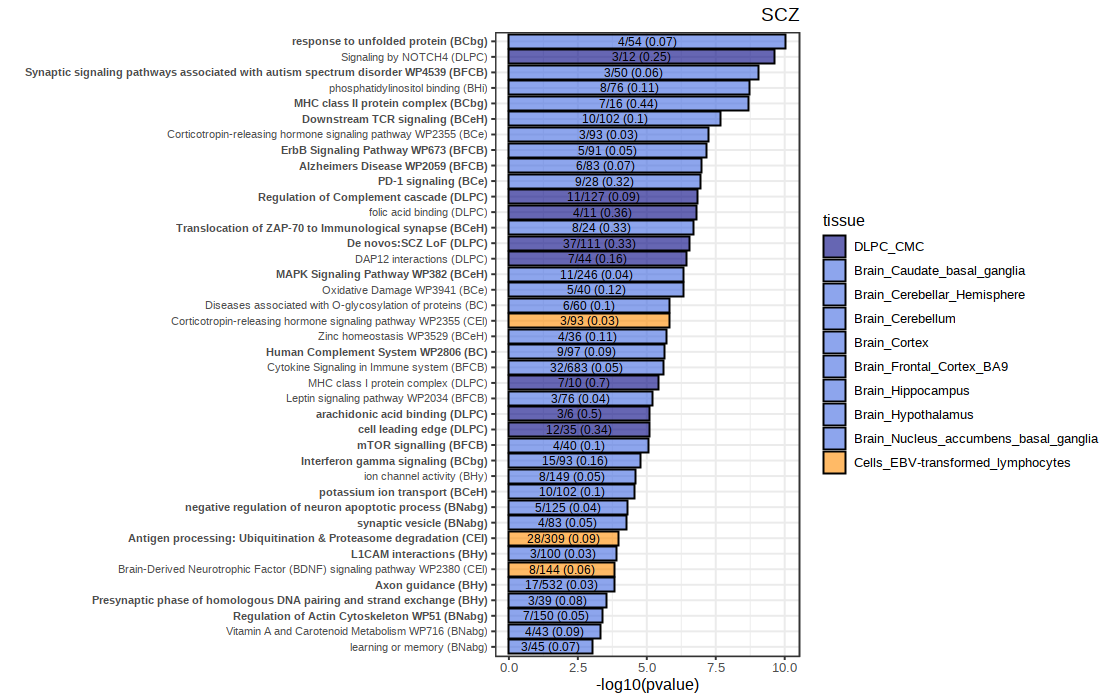

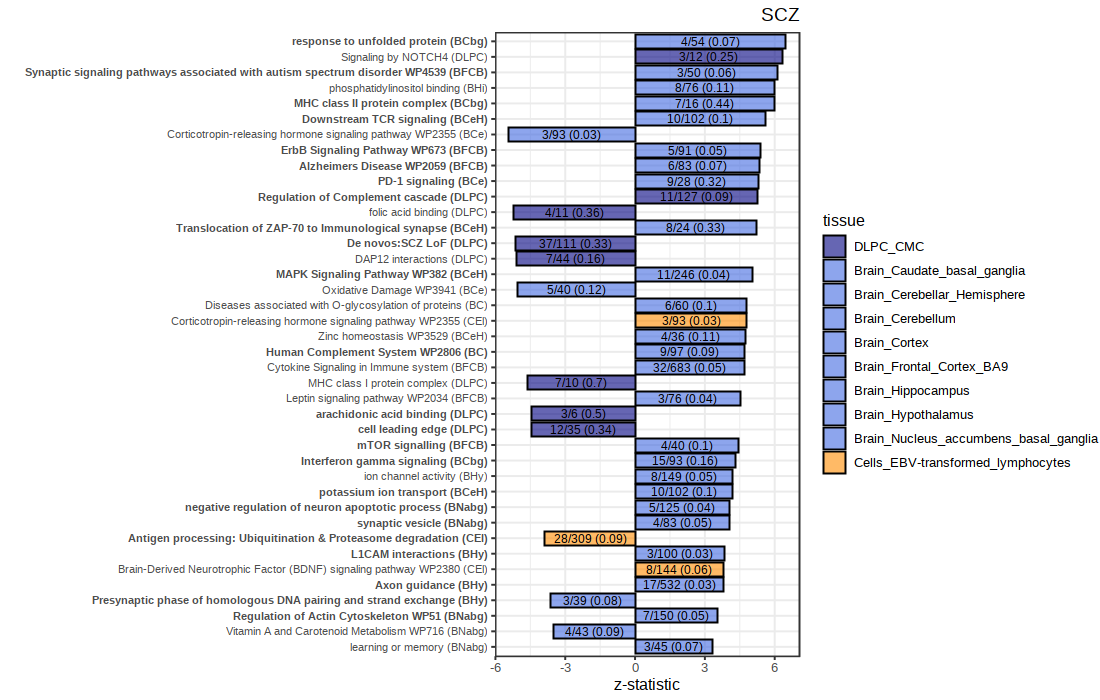

In [19]:
##############################################
### barplot selection significant pathways ###
##############################################
# Fig. 1C
options(repr.plot.width = 11, repr.plot.height = 7, repr.plot.res = 100)
keep_path_file <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/keep_path_SCZ_plot_v3.csv'

pathR$type <- 'Reactome'
pathGO$type <- 'GO'
pathCMC$type <- 'CMC'
pathWiki$type <- 'Wiki2019Human'
common_h <- intersect(colnames(pathCMC), intersect(colnames(pathWiki), intersect(colnames(pathR), colnames(pathGO))))
tot_path <- rbind(pathR[, match(common_h, colnames(pathR))], pathGO[, match(common_h, colnames(pathGO))], 
                  pathWiki[, match(common_h, colnames(pathWiki))], pathCMC[match(common_h, colnames(pathCMC))])

tmp_path <- read.csv(keep_path_file, h=T, stringsAsFactors = F)
tmp_path <- apply(tmp_path, 1, function(x) paste0(x, collapse = '_'))
tot_path_id <- apply(tot_path[, c('path', 'tissue', 'type')], 1, function(x) paste0(x, collapse = '_'))
best_path <- tot_path[match(tmp_path, tot_path_id), ]

best_path$logpval <-  -log10(best_path[, 13]) 
best_path$zstat <- best_path[, 12]
# save
pl <- plot_best_path(best_res = best_path, color_tissues = color_tissues, title_plot = pheno, type_mat = 'path', 
               outFold = out_fold, type_dat = type_dat, tissues = tissues, height_plot = 7, width_plot = 11, 
               id_pval = 13)
# plot
pl$pl_pval
pl$pl_zstat


[1] "cell leading edge"


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr2"
[1] "chr3"
[1] "chr5"
[1] "chr9"
[1] "chr10"
[1] "chr11"
[1] "chr15"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "De novos:SCZ LoF"


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "chr1"
[1] "chr2"
[1] "chr3"
[1] "chr4"
[1] "chr6"
[1] "chr7"
[1] "chr8"
[1] "chr9"
[1] "chr10"
[1] "chr11"
[1] "chr12"
[1] "chr14"
[1] "chr16"
[1] "chr17"
[1] "chr18"
[1] "chr19"
[1] "chr20"
[1] "chr22"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "Regulation of Complement cascade"


Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


[1] "chr1"
[1] "chr3"
[1] "chr6"
[1] "chr9"
[1] "chr11"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


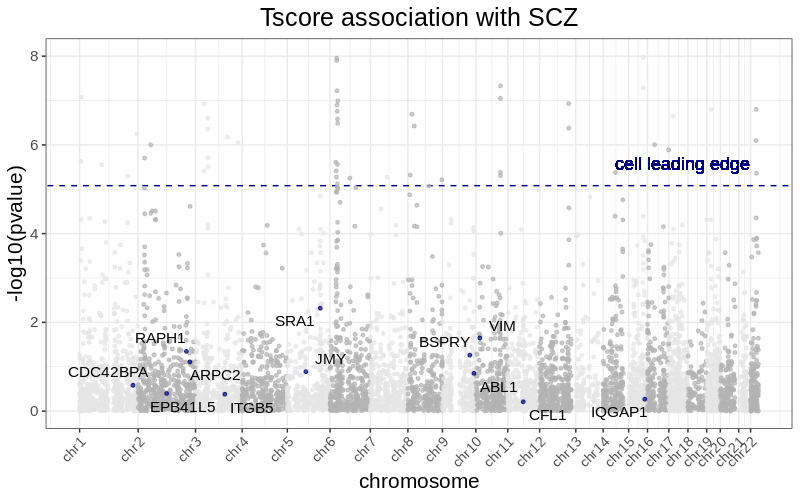

Warning message:
“Removed 29 rows containing missing values (geom_point).”


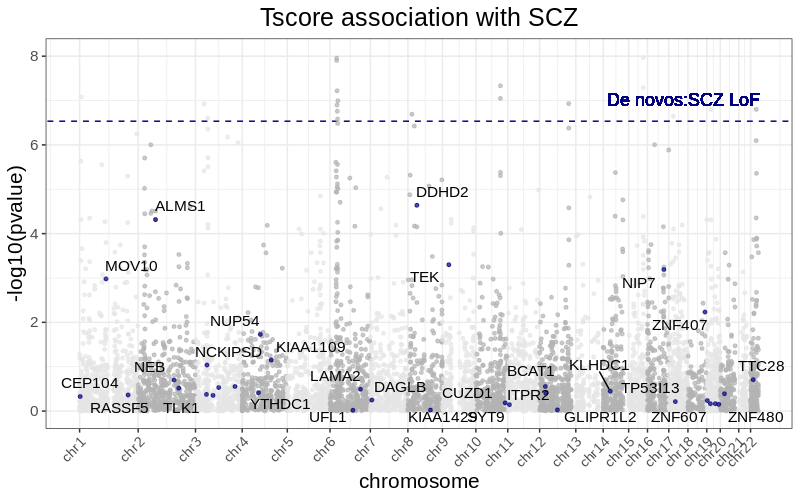

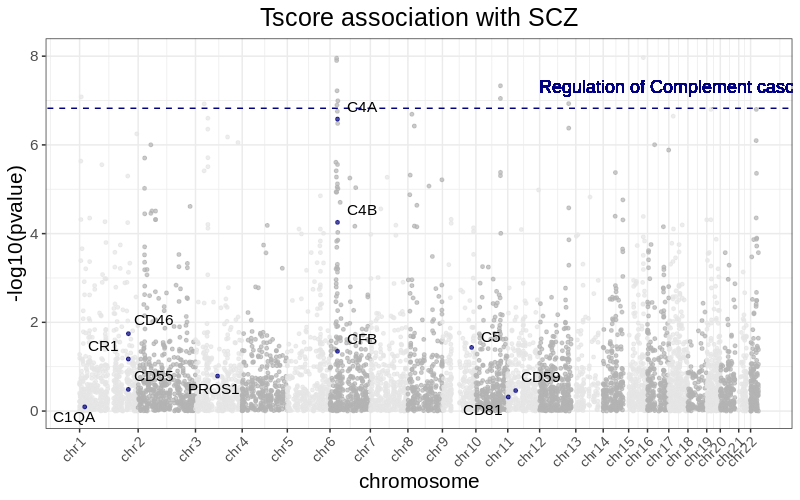

In [183]:
###################################
### showcase pathway enrichment ###
###################################

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

id_pval <- 1
tissue <- 'DLPC_CMC'
pathways <- c('cell leading edge', 'De novos:SCZ LoF', 'Regulation of Complement cascade')

train_fold_original <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/'
fold_tissue <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/'
fold_geno_input <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/Genotype_VariantsInfo_maf001_info06_CMC-PGCgwas-SCZ-PGCall_'

for(pathway in pathways){
    
    print(pathway)
    train_fold_tmp <- train_fold[which(tissues == tissue)]
    color_tmp <- color_tissues$color[color_tissues$tissues == tissue]
    id_pval_path <-13
    if(pathway == 'De novos:SCZ LoF'){
         info_res <- get(load(sprintf('%spval_Dx_pheno_covCorr_customPath_CMC_GeneSets.RData', fold_tissue[1])))
         id <- which(info_res$pathScore[[id_pval]]$path == pathway)
         genes_path <- info_res$info_pathScore[[id_pval]][[id]]  
    }else{
        info_res <- get(load(sprintf('%spval_Dx_pheno_covCorr.RData', fold_tissue[1])))
        id1 <- which(info_res$pathScore_reactome[[id_pval]]$path == pathway)
        id2 <- which(info_res$pathScore_GO[[id_pval]]$path == pathway)
        id <- ifelse(length(id1) > 0, id1, id2)
        if(length(id1) > 0){
          genes_path <- info_res$info_pathScore_reactome[[id_pval]][[id]]  
        }else{
          genes_path <- info_res$info_pathScore_GO[[id_pval]][[id]]
          id_pval_path <- 15
        }
        
    }
    
    gene_res <- info_res$tscore[[id_pval]]
    gene_info <- fread(sprintf('%sresPrior_regEval_allchr.txt', train_fold_tmp), h=T,stringsAsFactors = F, data.table = F)
    resBeta <- get(load(sprintf('%sresPrior_regCoeffSnps_allchr.RData', train_fold_tmp)))
    train_fold_tissue <- train_fold[grepl(tissue, train_fold)]
    
    # save
    pl <- plot_showcase(width_pl = 7, gene_res = gene_res, gene_info = gene_info, genes_path = genes_path, 
                  tissue = tissue, pathway = pathway, color_tmp = color_tmp, id_pval_path = id_pval_path, 
                  pheno = pheno, fold = out_fold, resBeta = resBeta, train_fold_tissue = train_fold_tmp, 
                  fold_geno_input_tmp = fold_geno_input, 
                  train_fold_original_tmp = train_fold_original, name_gwas_pval = 'PVAL')
    # warnings refer to most significant associations (in general) that are removed if not used in the pathway for display reasons
    # plot
    print(pl$pl_manh)    
}

  

[1] "potassium ion transport"


Warning message:
“Removed 17 rows containing missing values (geom_point).”
Warning message:
“Removed 17 rows containing missing values (geom_point).”


[1] "chr2"
[1] "chr5"
[1] "chr11"
[1] "chr12"
[1] "chr16"
[1] "chr17"
[1] "chr19"
[1] "chr20"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 17 rows containing missing values (geom_point).”


[1] "calcium ion transmembrane transport"


Warning message:
“Removed 17 rows containing missing values (geom_point).”
Warning message:
“Removed 17 rows containing missing values (geom_point).”


[1] "chr7"
[1] "chr9"
[1] "chr11"
[1] "chr12"
[1] "chr22"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22


Warning message:
“Removed 17 rows containing missing values (geom_point).”


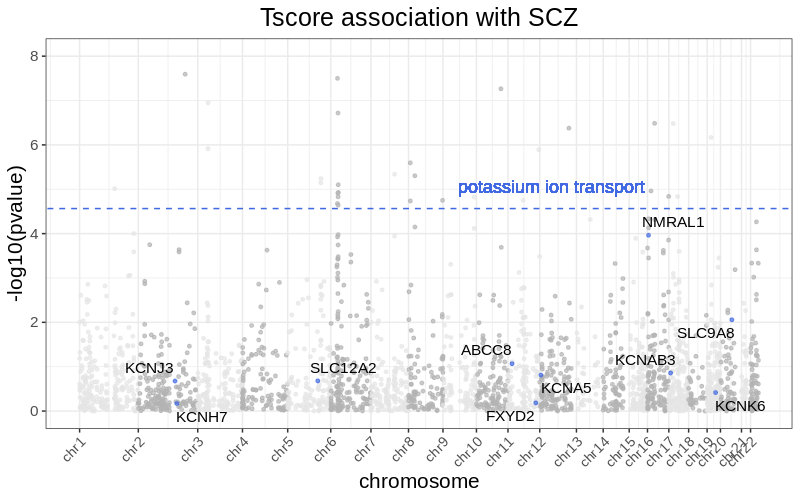

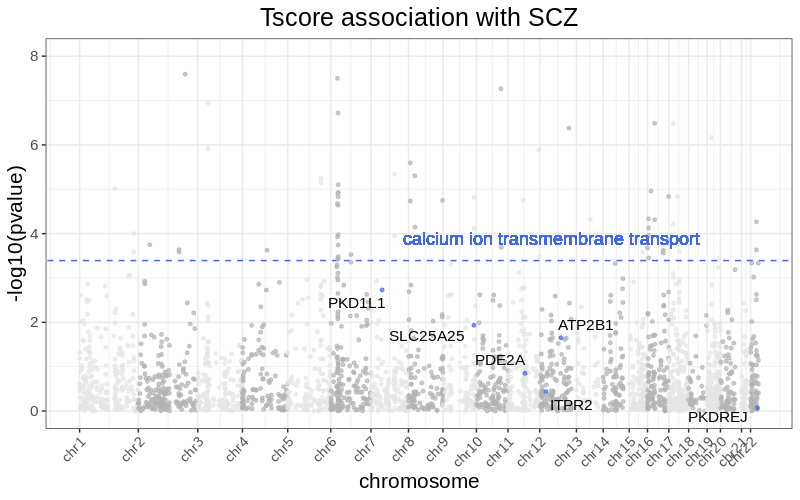

In [186]:
###################################
### showcase pathway enrichment ###
###################################

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)
source(functR)
id_pval <- 1
tissue <- 'Brain_Cerebellar_Hemisphere'
pathways <- c('potassium ion transport', 'calcium ion transmembrane transport')
train_fold_original <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/Brain_Cerebellar_Hemisphere/'
fold_tissue <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/Brain_Cerebellar_Hemisphere/'
fold_geno_input <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/Genotype_VariantsInfo_maf001_info06_CMC-PGCgwas-SCZ-PGCall_'

for(pathway in pathways){
    
    print(pathway)
    train_fold_tmp <- train_fold[which(tissues == tissue)]
    color_tmp <- color_tissues$color[color_tissues$tissues == tissue]
    id_pval_path <-13
    if(pathway == 'De novos:SCZ LoF'){
         info_res <- get(load(sprintf('%spval_Dx_pheno_covCorr_customPath_CMC_GeneSets.RData', fold_tissue[1])))
         id <- which(info_res$pathScore[[id_pval]]$path == pathway)
         genes_path <- info_res$info_pathScore[[id_pval]][[id]]  
    }else{
        info_res <- get(load(sprintf('%spval_Dx_pheno_covCorr.RData', fold_tissue[1])))
        id1 <- which(info_res$pathScore_reactome[[id_pval]]$path == pathway)
        id2 <- which(info_res$pathScore_GO[[id_pval]]$path == pathway)
        id <- ifelse(length(id1) > 0, id1, id2)
        if(length(id1) > 0){
          genes_path <- info_res$info_pathScore_reactome[[id_pval]][[id]]  
        }else{
          genes_path <- info_res$info_pathScore_GO[[id_pval]][[id]]
          id_pval_path <- 15
        }
        
    }
    
    gene_res <- info_res$tscore[[id_pval]]
    gene_info <- fread(sprintf('%sresPrior_regEval_allchr.txt', train_fold_tmp), h=T,stringsAsFactors = F, data.table = F)
    resBeta <- get(load(sprintf('%sresPrior_regCoeffSnps_allchr.RData', train_fold_tmp)))
    train_fold_tissue <- train_fold[grepl(tissue, train_fold)]
    
    # save
    pl <- plot_showcase(width_pl = 7, gene_res = gene_res, gene_info = gene_info, genes_path = genes_path, 
                  tissue = tissue, pathway = pathway, color_tmp = color_tmp, id_pval_path = id_pval_path, 
                  pheno = pheno, fold = out_fold, resBeta = resBeta, train_fold_tissue = train_fold_tmp, 
                  fold_geno_input_tmp = fold_geno_input, 
                  train_fold_original_tmp = train_fold_original, name_gwas_pval = 'PVAL')
    # warnings refer to most significant associations (in general) that are removed if not used in the pathway for display reasons
    # plot
    print(pl$pl_manh)    
}

  

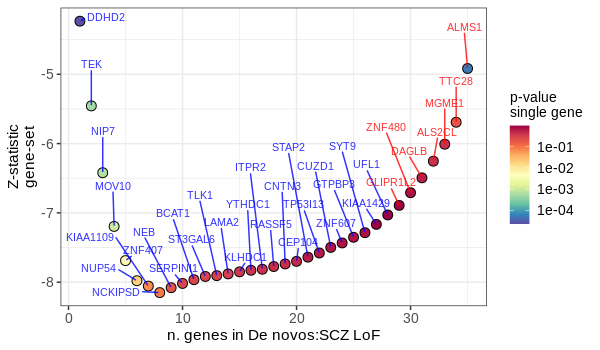

In [74]:
################################################
### incremental significance SCZ loF example ###
################################################
options(repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 100)
source(functR)
pval_incr <- get(load('SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/pval_Dx_pheno_covCorr_customPath_SCZ_LoF_signed_GeneSets.RData'))
path_info <- get(load('priler_project/refData/SCZ_LoF_signed_GeneSets_ordered.RData'))

# top to bottom
n_genes <- max(pval_incr$pathScore[[1]]$ngenes_tscore)
id <- which(sapply(path_info, function(x) x$name == sprintf('De novos:SCZ LoF most sign. n %i', n_genes)))
gene_order <- path_info[[35]]$geneIds

pl_incr <- plot_increment(gene_order = gene_order, path_res = pval_incr$pathScore[[1]][grepl('most', pval_incr$pathScore[[1]]$path), ], 
               gene_res = pval_incr$tscore[[1]], title_plot = 'SCZ_LoF_signed_GeneSets_decreasedOrder', fold = out_fold)

pl_incr


In [85]:
pval_incr$info_pathScore[[1]][[30]]$tscore %>% dplyr::arrange(Dx_pval)

ensembl_gene_id external_gene_name dev_geno   test_dev_geno Dx_beta      
1  ENSG00000085788 DDHD2              0.09611933 0.07208432    -0.0381423032
2  ENSG00000120156 TEK                0.12375424 0.04104790    -0.0307072586
3  ENSG00000132603 NIP7               0.04496145 0.02280835    -0.0303695850
4  ENSG00000155363 MOV10              0.06519354 0.01969208    -0.0292249965
5  ENSG00000215421 ZNF407             0.21959093 0.17598494    -0.0247525818
6  ENSG00000138750 NUP54              0.07942191 0.02101762    -0.0210742755
7  ENSG00000138688 KIAA1109           0.11351966 0.08071014    -0.0160641770
8  ENSG00000213672 NCKIPSD            0.29199043 0.27890147    -0.0150548088
9  ENSG00000183091 NEB                0.33825571 0.27563159    -0.0113645663
10 ENSG00000163536 SERPINI1           0.06392545 0.01657107    -0.0097214754
11 ENSG00000060982 BCAT1              0.21009677 0.06547852    -0.0095884352
12 ENSG00000064225 ST3GAL6            0.10670355 0.05315290    -0.0093250828
13 ENSG00000198586 TLK1               0.10914476 0.01004037    -0.0091762286
14 ENSG00000196569 LAMA2              0.07168443 0.02450866    -0.0088570203
15 ENSG00000197776 KLHDC1             0.19404811 0.01480949    -0.0082651607
16 ENSG00000083896 YTHDC1             0.05466924 0.02228513    -0.0077739195
17 ENSG00000123104 ITPR2              0.35583228 0.29579780    -0.0076254938
18 ENSG00000136653 RASSF5             0.05750568 0.01258115    -0.0070004897
19 ENSG00000113805 CNTN3              0.07210710 0.01075325    -0.0068436785
20 ENSG00000116198 CEP104             0.13984044 0.10369093    -0.0064585847
21 ENSG00000178078 STAP2              0.08759112 0.06421367    -0.0049341361
22 ENSG00000167543 TP53I13            0.06149463 0.01921150    -0.0045266048
23 ENSG00000138161 CUZD1              0.16224609 0.09664323    -0.0040015056
24 ENSG00000198182 ZNF607             0.07469541 0.04752029    -0.0036722097
25 ENSG00000130299 GTPBP3             0.24967225 0.08872727    -0.0036561425
26 ENSG00000198464 ZNF480             0.13851762 0.06113814     0.0033581221
27 ENSG00000170743 SYT9               0.05894045 0.01955422    -0.0031992486
28 ENSG00000180481 GLIPR1L2           0.74809251 0.72305667     0.0006859614
29 ENSG00000164944 KIAA1429           0.09405472 0.02178584    -0.0005719401
30 ENSG00000014123 UFL1               0.14834836 0.06028179    -0.0004956071
   Dx_se_beta  Dx_z        Dx_pval      Dx_qval     Dx_pval_BHcorr
1  0.009009048 -4.23377753 2.297983e-05 0.001113164 0.001593021   
2  0.008824471 -3.47978457 5.018171e-04 0.011593280 0.016590846   
3  0.008902473 -3.41136495 6.463851e-04 0.013544044 0.019382535   
4  0.008916763 -3.27753442 1.047180e-03 0.020247002 0.028974966   
5  0.008980518 -2.75625330 5.846770e-03 0.062713664 0.089747918   
6  0.008964836 -2.35077095 1.873456e-02 0.129845126 0.185818034   
7  0.008890929 -1.80680529 7.079264e-02 0.253760151 0.363149653   
8  0.008925315 -1.68675384 9.165070e-02 0.285142966 0.408060796   
9  0.008862065 -1.28238360 1.997081e-01 0.406178979 0.581272334   
10 0.008973558 -1.08334675 2.786545e-01 0.465708117 0.666462959   
11 0.008855439 -1.08277362 2.789089e-01 0.465708117 0.666462959   
12 0.008908517 -1.04676035 2.952101e-01 0.477590028 0.683466857   
13 0.008919253 -1.02881139 3.035683e-01 0.482497691 0.690490089   
14 0.008940734 -0.99063676 3.218630e-01 0.491741728 0.703718993   
15 0.008925533 -0.92601310 3.544392e-01 0.503617701 0.720714394   
16 0.008925906 -0.87093902 3.837874e-01 0.517499281 0.740579968   
17 0.008973791 -0.84975165 3.954632e-01 0.519216401 0.743037294   
18 0.008936723 -0.78333967 4.334277e-01 0.539558872 0.772148884   
19 0.008922855 -0.76698308 4.430916e-01 0.541248473 0.774566828   
20 0.008935587 -0.72279352 4.698067e-01 0.548453650 0.784877972   
21 0.008901418 -0.55430900 5.793674e-01 0.594550174 0.850845527   
22 0.008911418 -0.50795562 6.114845e-01 0.606575276 0.868054343   
23 0.008896286 -0.44979507 6.528582e-01 0.619723917 0.886871027   
24 0.008

Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"cl.lim" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"cl.lim" is not a graphical parameter”
Warning message in title(title, ...):
“"cl.lim" is not a graphical parameter”


png 
  2

Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"cl.lim" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"cl.lim" is not a graphical parameter”
Warning message in title(title, ...):
“"cl.lim" is not a graphical parameter”


png 
  2

Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"cl.lim" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"cl.lim" is not a graphical parameter”
Warning message in title(title, ...):
“"cl.lim" is not a graphical parameter”


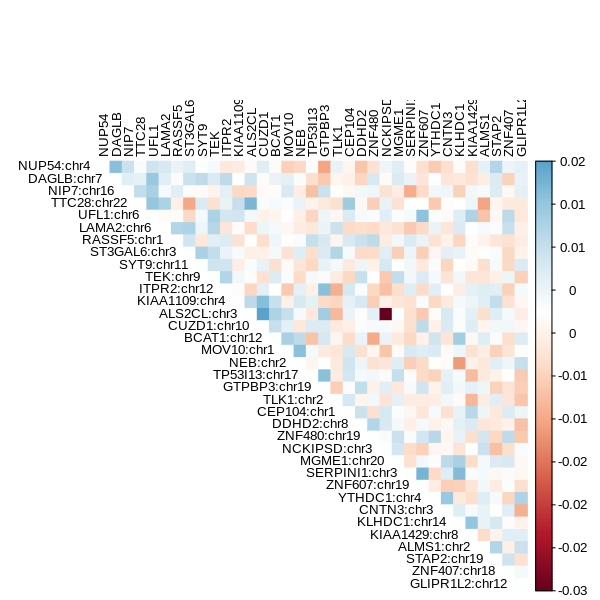

In [188]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)

cor_res <- get(load('SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/cor_custom_geneList_SCZ_LoF_GeneSets_combined.RData'))
cor_mat <- cor_res$cor
diag(cor_mat) <- 0
new_name <- paste0(colnames(cor_mat), ':', cor_res$geneAnn$chrom)
rownames(cor_mat) <- new_name

# col <- colorRampPalette(brewer.pal(9, 'Oranges'))(100)
val <- round(max(abs(cor_mat), na.rm = T), digits = 2)

ord <- corrMatOrder(cor_mat, order="hclust", hclust.method = 'ward.D')

pdf(file = sprintf('%scorr_genes_SCZ_LoF.pdf', out_fold), width = 6, height = 6, compress = F)
corrplot(cor_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',cl.lim = c(-val,val), 
         method = 'color', tl.srt=90, cl.align.text='c',tl.col = "black", tl.cex = 0.8, 
         na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,5,0))
dev.off()

png(file = sprintf('%scorr_genes_SCZ_LoF.png', out_fold), units = 'in', width = 6, height = 6, res = 300)
corrplot(cor_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',cl.lim = c(-val,val), 
         method = 'color', tl.srt=90, cl.align.text='c', tl.col = "black", tl.cex = 0.8, 
         na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,5,0))
dev.off()

corrplot(cor_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',cl.lim = c(-val,val), 
         method = 'color', tl.srt=90, cl.align.text='c', tl.col = "black", tl.cex = 0.8, 
         na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,5,0))


[1] 75

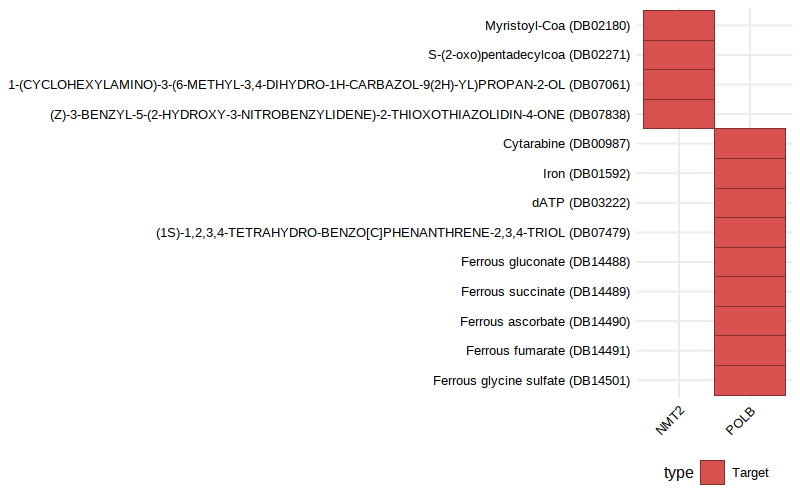

In [61]:
######################################
### annotate genes by drug targets ###
######################################

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)
library(drugbankR)
drugbank_genes <- 'refData/drugBank/All_geneTargets_enzymes.txt'
df <- queryDB(type = "getAll", db_path=sprintf("%sdrugbank_5.1.7.db", 'refData/drugBank/'))
id_SCZ = unique(c(grep("schizophrenia", df$`mechanism-of-action`), grep("schizophrenia", df$indication)))
name_SCZ <- unique(df[id_SCZ, "drugbank-id"])

genes_sign <- unique(tscore_complete$external_gene_name)
genes_new <- unique(tscore_complete$external_gene_name[!tscore_complete$best_GWAS_signBH])
db_genes <- fread(drugbank_genes, h=T, stringsAsFactors = F, data.table = F)

db_genes_sign <- db_genes[db_genes$gene %in% genes_new,]
db_genes_sign <- db_genes_sign[order(db_genes_sign$gene), ]

# create 0-1 matrix drugs x targets
db_drug_name <- db_genes_sign[!duplicated(db_genes_sign$id), 1:2]
drug_gene_mat <- matrix(0,nrow = nrow(db_drug_name), ncol = length(unique(db_genes_sign$gene)))
rownames(drug_gene_mat) <- paste0(db_drug_name$drug, ' (', db_drug_name$id, ')')
colnames(drug_gene_mat) <- unique(db_genes_sign$gene)
for(i in 1:nrow(db_drug_name)){
    id <- colnames(drug_gene_mat) %in% db_genes_sign$gene[db_genes_sign$id == db_drug_name$id[i]]
    gene_type <- sapply(which(id), function(x) db_genes_sign$class[db_genes_sign$id == db_drug_name$id[i] & db_genes_sign$gene == colnames(drug_gene_mat)[x]])
    drug_gene_mat[i, id] <- gene_type
}
#drug_gene_mat
                        
# plot 
db_genes_sign$new_name <- paste0(db_genes_sign$drug, ' (', db_genes_sign$id, ')') 
db_genes_sign$new_name <- factor(db_genes_sign$new_name, levels = rev(unique(db_genes_sign$new_name)))
db_genes_sign$type <- NA
db_genes_sign$type[db_genes_sign$class == 'E'] <- 'Enzyme'
db_genes_sign$type[db_genes_sign$class == 'TR'] <- 'Transporters'           
db_genes_sign$type[db_genes_sign$class == 'T'] <- 'Target'
db_genes_sign$type <- factor(db_genes_sign$type, levels = c('Target', 'Transporters', 'Enzyme'))

pl <- ggplot(db_genes_sign, aes(gene, new_name)) + 
            geom_tile(aes(fill = type), colour = "black") + 
            theme_minimal()+
            theme(axis.title = element_blank(), axis.text = element_text(color = 'black'), 
                 axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'bottom')+
            scale_fill_manual(values=c("#D9514EFF", "#2A2B2DFF", "#2DA8D8FF"))
pl
# save
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.png', out_fold, pheno), plot = pl, width = 8, height = 5, dpi = 500)
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.pdf', out_fold, pheno), plot = pl, width = 8, height = 5, compress = F)
  

In [62]:
#########################################
### annotate pathways by drug targets ###
#########################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
path_ann_drug <- path_complete_ann
#path_ann_drug <- path_complete_ann[path_complete_ann$type_path %in% c('Reactome', 'GO') & path_complete_ann$class_pathway == "pathway P < genes P & genes FDR > 0.05", ]
#path_ann_drug <- path_ann_drug[(path_ann_drug$path %in% pathGO$path[pathGO$path_ont %in% c('BP' & 'MF')] & path_ann_drug$type_path %in% 'GO') | path_ann_drug$type_path %in% 'Reactome',]
path_ann_drug <- path_ann_drug[, c('path', 'ngenes_tscore', 'Dx_z', 'Dx_pval', 'Dx_pval_BHcorr', 'genes_path', 'tissue', 'class_pathway', 'type_path')]

path_ann_drug$drugBank_ann <- NA
path_ann_drug$drugBank_n <- NA
path_ann_drug$drugBank_id <- NA
path_ann_drug$drugBank_gene <- NA
path_ann_drug$drugBank_usedForSCZ <- NA

for(i in 1:nrow(path_ann_drug)){
    path_name = path_ann_drug$path[i]
    genes_path <- strsplit(path_ann_drug$genes_path[path_ann_drug$path == path_name], split = ',')[[1]]
    drug_ann <- db_genes[db_genes$gene %in% genes_path,,drop = F]
    path_ann_drug$drugBank_ann[i] <- paste0(unique(drug_ann$drug), collapse = '-and-')
    path_ann_drug$drugBank_id[i] <- paste0(unique(drug_ann$id), collapse = '-and-')
    path_ann_drug$drugBank_n[i] <- nrow(drug_ann)
    path_ann_drug$drugBank_gene[i] <- paste0(unique(drug_ann$gene), collapse = '-and-')
    path_ann_drug$drugBank_usedForSCZ[i] <- paste0(unique(drug_ann$drug[drug_ann$id %in% name_SCZ]), collapse = '-and-')
}

# save table
write.table(path_ann_drug, file = sprintf('%sPathScore_SCZ_annotated_drugBank.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

# reduce category
path_ann_drug_red <- path_ann_drug[path_ann_drug$type_path %in% c('Reactome', 'GO') & path_ann_drug$class_pathway == "pathway P < genes P & genes FDR > 0.05", ]
path_ann_drug_red <- path_ann_drug_red[(path_ann_drug_red$path %in% pathGO$path[pathGO$path_ont %in% c('BP', 'MF')] & path_ann_drug_red$type_path %in% 'GO') | path_ann_drug_red$type_path %in% 'Reactome',]
# save table
write.table(path_ann_drug_red, file = sprintf('%sPathScore_SCZ_annotated_drugBank_notSignGenes_GOandReactome.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)